# Import packages

In [284]:
%load_ext autoreload
%autoreload 2

import os, sys, sys
from pathlib import Path
for p in [Path.cwd()] + list(Path.cwd().parents):
    if p.name == 'Multifirefly-Project':
        os.chdir(p)
        sys.path.insert(0, str(p / 'multiff_analysis/multiff_code/methods'))
        break

from data_wrangling import specific_utils, process_monkey_information, general_utils
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from neural_data_analysis.neural_analysis_tools.get_neural_data import neural_data_processing
from neural_data_analysis.neural_analysis_tools.visualize_neural_data import plot_neural_data, plot_modeling_result
from neural_data_analysis.neural_analysis_tools.model_neural_data import transform_vars, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from neural_data_analysis.topic_based_neural_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from neural_data_analysis.topic_based_neural_analysis.planning_and_neural import planning_and_neural_class, pn_utils, pn_helper_class
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class, cca_utils, cca_cv_utils
from neural_data_analysis.neural_analysis_tools.cca_methods.cca_plotting import cca_plotting, cca_plot_lag_vs_no_lag, cca_plot_cv
from machine_learning.ml_methods import regression_utils, ml_methods_utils, regz_regression_utils, ml_methods_class, classification_utils, ml_plotting_utils
from neural_data_analysis.design_kits.design_by_segment import create_design_df, predictor_utils, other_feats
from neural_data_analysis.topic_based_neural_analysis.planning_and_neural import planning_and_neural_class, pn_utils, pn_helper_class, pn_aligned_by_seg, pn_aligned_by_event, pn_glm_utils
from neural_data_analysis.neural_analysis_tools.glm_tools.tpg import glm_bases, glm_plotting, glm_plotting2, glm_fit

from neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_psth import core_stops_psth, get_stops_utils, psth_postprocessing, psth_stats, compare_events, dpca_utils
from neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_glm.glm_fit import stop_glm_fit, cv_stop_glm, glm_fit_utils, variance_explained
from neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_glm.glm_plotting import plot_spikes, plot_glm_fit, plot_tuning_func
from neural_data_analysis.design_kits.design_around_event import event_binning, stop_design, cluster_design, design_checks
from neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_glm.glm_hyperparams import compare_glm_configs, glm_hyperparams_class
from neural_data_analysis.neural_analysis_tools.glm_tools.glm_decoding_tools import glm_decoding_llr, glm_decoding


import sys
import math
import gc
import subprocess
from pathlib import Path
from importlib import reload

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
from numpy import pi

from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Retrieve data

## get data

In [3]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"

In [4]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0312"

In [83]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"

In [ ]:
reduce_y_var_lags = False
planning_data_by_point_exists_ok = True
y_data_exists_ok = True

pn = pn_aligned_by_event.PlanningAndNeuralEventAligned(raw_data_folder_path=raw_data_folder_path)
pn.prep_data_to_analyze_planning(planning_data_by_point_exists_ok=planning_data_by_point_exists_ok)
#pn.get_x_and_y_data_for_modeling(exists_ok=y_data_exists_ok, reduce_y_var_lags=reduce_y_var_lags)

pn.rebin_data_in_new_segments(cur_or_nxt='cur', first_or_last='first', time_limit_to_count_sighting=2,
                                 pre_event_window=0, post_event_window=1.5, rebinned_max_x_lag_number=2)

for col in ['cur_vis', 'nxt_vis', 'cur_in_memory', 'nxt_in_memory']:
    pn.rebinned_y_var[col] = (pn.rebinned_y_var[col] > 0).astype(int)

Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0330/binned_spikes_df_0p05.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0330/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0330/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0330/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
There are 4 duplicated point_index in bin_info. Note: one_point_index_per_bin is False
Dropped 7 columns with more than 30.0% missing values: ['stop_id_end_time', 'stop_id_start_time', 'stop_id_duration', 'stop_cluster_start_point', 'stop_cluster_id', 's

/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)


In [ ]:
rebinned_x_var = pn.rebinned_x_var.copy()
rebinned_y_var = pn.rebinned_y_var.copy()

## select subset

### get heading data

In [ ]:
heading_info_df, heading_df = pn_glm_utils.get_test_heading_df(raw_data_folder_path)

In [264]:
rebinned_x_var, rebinned_y_var = pn_glm_utils.select_ff_subset(heading_df, pn.rebinned_x_var, pn.rebinned_y_var, 
                                                               top=False, pct=0.5)
rebinned_x_var = pn_glm_utils.drop_constant_columns(rebinned_x_var)

Selecting 196 rows from the bottom of heading_df (total=393)
rebinned_y_var.shape (before): (9339, 143)
rebinned_y_var.shape (after): (2673, 143)


# GLM data

In [260]:
reload(create_design_df)
reload(other_feats)

data = rebinned_y_var.copy()
trial_ids = data['new_segment']
dt = pn.bin_width

design_df, meta0, meta = create_design_df.get_initial_design_df(data, dt, trial_ids)

cluster_num = 3
y = rebinned_x_var[f'cluster_{cluster_num}']

# design_df, meta = create_design_df.add_spike_history(
#     design_df, y, meta0['trial_ids'], dt,
#     n_basis=4, t_max=0.20, edge='zero',
#     prefix='spk_hist', style='bjk',
#     meta=meta
# )

chk = predictor_utils.check_design_vs_bases(design_df, meta, strict=True)
assert chk['ok'], chk['problems']


df_X = design_df[['speed_z', 'time_since_last_capture',
       'ang_accel_mag_spline:s0', 'ang_accel_mag_spline:s1',
       'ang_accel_mag_spline:s2', 'ang_accel_mag_spline:s3', 'cur_vis', 'nxt_vis']].copy()

print('df_X.shape:', df_X.shape)
cluster_cols = [col for col in rebinned_x_var.columns if col.startswith('cluster_')]
df_Y = rebinned_x_var[cluster_cols]
df_Y.columns = df_Y.columns.str.replace('cluster_', '').astype(int)



df_X['random_0_or_1'] = np.random.randint(0, 2, len(df_X))

df_X.shape: (2673, 8)


## other ways of taking out data

In [ ]:
df_X = design_df[['speed_z', 'time_since_last_capture',
       'ang_accel_mag_spline:s0', 'ang_accel_mag_spline:s1',
       'ang_accel_mag_spline:s2', 'ang_accel_mag_spline:s3'] + cur_ff_cols + nxt_ff_cols].copy()

print('df_X.shape:', df_X.shape)
cluster_cols = [col for col in rebinned_x_var.columns if col.startswith('cluster_')]
df_Y = rebinned_x_var[cluster_cols]
df_Y.columns = df_Y.columns.str.replace('cluster_', '').astype(int)

df_X.shape: (9339, 43)


In [ ]:
# #df_X = design_df

# # cur_ff_distance_cols = [col for col in design_df.columns if 'cur_ff_distance' in col]
# # df_X = design_df[cur_ff_distance_cols + ['const']]

cur_ff_cols = [col for col in design_df.columns if ('cur_' in col) and ('cur_in_memory' not in col)]
nxt_ff_cols = [col for col in design_df.columns if 'nxt_' in col]

# # df_X = design_selected

# # df_X = design_selected.copy()

# df_X = design_df[['speed_z', 'time_since_last_capture',
#        'ang_accel_mag_spline:s0', 'ang_accel_mag_spline:s1',
#        'ang_accel_mag_spline:s2', 'ang_accel_mag_spline:s3']].copy()
# df_X[cur_ff_distance_cols] = design_df[cur_ff_distance_cols].copy()

# print('df_X.shape:', df_X.shape)
# cluster_cols = [col for col in rebinned_x_var.columns if col.startswith('cluster_')]
# df_Y = rebinned_x_var[cluster_cols]
# df_Y.columns = df_Y.columns.str.replace('cluster_', '').astype(int)


# Fit glm

In [290]:
exposure = np.full_like(y, fill_value=pn.bin_width, dtype=float)
offset_log = np.log(exposure)

report = stop_glm_fit.glm_mini_report(
    df_X=df_X, df_Y=df_Y, offset_log=offset_log,
    cov_type='HC1', 
    fast_mle=True,
    do_inference=False, 
    make_plots=True,
    show_plots=True,
)


Skipping terms with no significant clusters (sig_FDR=0): ['ang_accel_mag_spline:s0', 'nxt_vis']
[glm_mini_report] WARNING: could not build figures: KeyError: 'rr'
[glm_mini_report] Finished fast MLE on 16 clusters, cov_type=HC1, inference=False, plots=True
[glm_mini_report] offenders: 4


# Decoding

## run

In [ ]:
exposure = np.ones(len(df_X)) * pn.bin_width
offset_log = np.log(exposure)
cols_to_decode = ['nxt_vis', 'random_0_or_1', 'cur_vis']
glm_decoding.glm_decoding_from_fit(cols_to_decode, df_X, df_Y, offset_log, report)

----------------------------------------------------------------------------------------------------
nxt_vis: mean = 0.14739992517770295
AUC=0.532, PR-AUC=0.159
----------------------------------------------------------------------------------------------------
random_0_or_1: mean = 0.494949494949495
AUC=0.504, PR-AUC=0.509
----------------------------------------------------------------------------------------------------
cur_vis: mean = 0.2888140665918444
AUC=0.589, PR-AUC=0.371


## CV

In [ ]:
cols_to_decode = ['nxt_vis']
groups = np.array(data['new_segment'])
glm_decoding.glm_decoding_cv(cols_to_decode, df_X, df_Y, groups, offset_log)

[glm_mini_report] Finished fast MLE on 16 clusters, cov_type=HC1, inference=False, plots=False
[glm_mini_report] offenders: 4
[align_params_to_Y] WARNING: 1 Y units missing; filling with 0.0. Examples: ['11']
[glm_mini_report] Finished fast MLE on 16 clusters, cov_type=HC1, inference=False, plots=False
[glm_mini_report] offenders: 4
[glm_mini_report] Finished fast MLE on 16 clusters, cov_type=HC1, inference=False, plots=False
[glm_mini_report] offenders: 3
[glm_mini_report] Finished fast MLE on 16 clusters, cov_type=HC1, inference=False, plots=False
[glm_mini_report] offenders: 4
[glm_mini_report] Finished fast MLE on 16 clusters, cov_type=HC1, inference=False, plots=False
[glm_mini_report] offenders: 4
----------------------------------------------------------------------------------------------------
nxt_vis:
GroupKFold AUC: 0.493 ± 0.021 | PR-AUC: 0.151 ± 0.022 | folds=5
fold 1: AUC=0.496, PR-AUC=0.127, n_test=529, kept=529
fold 2: AUC=0.465, PR-AUC=0.157, n_test=535, kept=535
fold 

## permutations

In [ ]:
cols_to_decode = ['random_0_or_1', 'nxt_vis', 'cur_vis']
groups = np.array(data['new_segment'])
glm_decoding.glm_decoding_permutation_test(cols_to_decode, df_X, df_Y,
                          groups, offset_log, report)


# GLM (code from stop glm)

## check fitting


In [174]:
coefs_df    = report['coefs_df']
metrics_df  = report['metrics_df']
pop_tests   = report['population_tests_df']
metrics_df

cluster  n_obs   deviance  null_deviance         llf      llnull  \
0         0   1601  679.16067      717.28419  -465.94756  -485.00932   
1         1   1601  837.40622      869.75988  -603.37719  -619.55402   
2         2   1601  879.11747      927.77301  -590.81434  -615.14211   
3         3   1601  924.36759      971.94437  -666.57845  -690.36684   
4         4   1601 1785.39474     1557.71080 -1530.72574 -1416.88377   
5         5   1601    3.83875       26.74095    -3.91938   -15.37047   
6         6   1601   48.71164       47.93671   -28.35582   -27.96836   
7         7   1601 1277.21044     1289.96546 -1022.50692 -1028.88442   
8         8   1601  225.71862      238.18827  -140.47302  -146.70784   
9         9   1601  786.38122      795.44602  -540.66746  -545.19987   
10       10   1601  679.56102      700.19265  -430.60542  -440.92123   
11       11   1601        NaN            NaN         NaN         NaN   
12       12   1601 1083.96211     1061.18957  -788.94292  -777.55665   
13       13   1601   49.62692       47.93671   -28.81346   -27.96836   
14       14   1601  430.39337      449.68461  -274.14743  -283.79305   
15       15   1601  343.91386      357.09410  -221.57064  -228.16076   

    deviance_explained  mcfadden_R2   alpha   l1_wt  converged  \
0              0.05315      0.03930 0.00000 0.00000       True   
1              0.03720      0.02611 0.00000 0.00000       True   
2              0.05244      0.03955 0.00000 0.00000       True   
3              0.04895      0.03446 0.00000 0.00000       True   
4             -0.14617     -0.08035 0.00000 0.00000       True   
5              0.85645      0.74501 0.00000 0.00000       True   
6             -0.01617     -0.01385 0.00000 0.00000       True   
7              0.00989      0.00620 0.00000 0.00000       True   
8              0.05235      0.04250 0.00000 0.00000       True   
9              0.01140      0.00831 0.00000 0.00000       True   
10             0.02947      0.02340 0.00000 0.00000       True   
11                 NaN          NaN 0.00000 0.00000      False   
12            -0.02146     -0.01464 0.00000 0.00000       True   
13            -0.03526     -0.03022 0.00000 0.00000       True   
14             0.04290      0.03399 0.00000 0.00000       True   
15             0.03691      0.02888 0.00000 0.00000       True   

    used_ridge_fallback convergence_message  nonzeros  zero_frac    condX  \
0                 False           newton_ok       122    0.92380 55.49577   
1                 False           newton_ok       180    0.88757 55.49577   
2                 False           newton_ok       139    0.91318 55.49577   
3                 False           newton_ok       195    0.87820 55.49577   
4                 False           newton_ok       598    0.62648 55.49577   
5                 False           newton_ok         2    0.99875 55.49577   
6                 False           newton_ok         4    0.99750 55.49577   
7                 False           newton_ok       367    0.77077 55.49577   
8                 False           newton_ok        27    0.98314 55.49577   
9                 False           newton_ok       142    0.91131 55.49577   
10                False           newton_ok        82    0.94878 55.49577   
11                False       all_zero_unit         0    1.00000 55.49577   
12                False           newton_ok       237    0.85197 55.49577   
13                False           newton_ok         4    0.99750 55.49577   
14                False           newton_ok        56    0.96502 55.49577   
15                False           newton_ok        49    0.96939 55.49577   

    offender skipped_zero_unit  
0      False               NaN  
1      False               NaN  
2      False               NaN  
3      False               NaN  
4      False               NaN  
5       True               NaN  
6      False               NaN  
7      False               NaN  
8      False               NaN  
9      False    

## VE

In [108]:
reload(variance_explained)
df_Y_pred = variance_explained.build_df_Y_pred_from_results(
    results=report['results'],
    df_X=df_X,
    offset_log=offset_log,
    df_Y=df_Y
)

# sanity checks
assert df_Y_pred.shape == df_Y.shape
assert np.isfinite(df_Y_pred.values).all()

Clusters had NaN/inf in fittedvalues (Recomputed): [5, 11, 13]


/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


In [ ]:
# Convert observed/predicted DataFrames to arrays
X = df_Y.to_numpy()      # observed counts
X_hat = df_Y_pred.to_numpy() # predicted expected counts
#event_ids = meta_used['event_id'].to_numpy()
event_ids = rebinned_x_var['new_segment'].to_numpy()

ve_pop, k_eff = variance_explained.population_VE_in_PCspace(X, X_hat, k=10, center='neuron')


Mean single-neuron VE:   0.029
Median single-neuron VE: 0.011


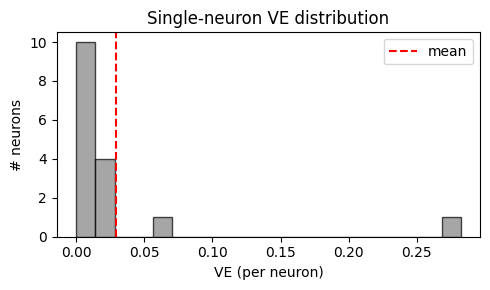

Population VE in 10 PCs: 0.020


In [110]:
ve_per_neuron, ve_mean = variance_explained.single_neuron_temporal_VE(X, X_hat, aggregate='mean')
ve_median = float(np.median(ve_per_neuron))

print(f'Mean single-neuron VE:   {ve_mean:.3f}')
print(f'Median single-neuron VE: {ve_median:.3f}')

variance_explained.plot_single_neuron_VE_hist(ve_per_neuron)

ve_pop, k_eff = variance_explained.population_VE_in_PCspace(X, X_hat, k=10, center='neuron')
print(f'Population VE in {k_eff} PCs: {ve_pop:.3f}')

variance_explained.plot_population_VE_bar(ve_pop)


In [111]:
np.sort(ve_per_neuron)

array([0.     , 0.     , 0.     , 0.     , 0.00576, 0.00697, 0.00736,
       0.00925, 0.01315, 0.01359, 0.01555, 0.01657, 0.01798, 0.01858,
       0.05755, 0.28224])

In [112]:
import numpy as np
from sklearn.cross_decomposition import CCA

def population_ve_cca(X, Y, n_components=10):
    """
    Canonical correlation analysis between observed (X) and predicted (Y).

    Parameters
    ----------
    X : array, shape (samples, neurons)
    Y : array, shape (samples, neurons) -- same shape as X
    n_components : number of canonical pairs to compute

    Returns
    -------
    corrs : array of canonical correlations (length n_components)
    mean_corr : average canonical correlation across components
    """
    X = np.asarray(X, float)
    Y = np.asarray(Y, float)
    assert X.shape == Y.shape, 'X and Y must have same shape'

    cca = CCA(n_components=n_components, max_iter=1000)
    Xc, Yc = cca.fit_transform(X, Y)
    corrs = [np.corrcoef(Xc[:,i], Yc[:,i])[0,1] for i in range(Xc.shape[1])]
    return np.array(corrs), np.mean(corrs)

corrs, mean_corr = population_ve_cca(X, X_hat, n_components=10)
print('Canonical correlations:', corrs)
print('Mean correlation:', mean_corr)

Canonical correlations: [0.53406 0.25229 0.16888 0.14996 0.12655 0.11985 0.09958 0.09482 0.08322
 0.07489]
Mean correlation: 0.17041150834793165


In [113]:
def reduced_rank_regression(X, Y, rank=10):
    """
    Reduced-rank regression: regress Y onto X with low-rank constraint.

    Returns regression coefficients B of shape (X_dim, Y_dim).
    """
    # Center
    Xc = X - X.mean(0, keepdims=True)
    Yc = Y - Y.mean(0, keepdims=True)

    # Solve full regression
    B_ols, _, _, _ = np.linalg.lstsq(Xc, Yc, rcond=None)

    # Project coefficient matrix onto low-rank space
    U, s, Vt = np.linalg.svd(B_ols, full_matrices=False)
    B_rr = U[:, :rank] @ np.diag(s[:rank]) @ Vt[:rank, :]
    return B_rr

B_rr = reduced_rank_regression(X, X_hat, rank=5)

In [114]:
# Per-stop breakdown (good for figures)
per_stop_df = variance_explained.per_event_breakdown(X, X_hat, event_ids=event_ids, k=10)
print(per_stop_df.head())

summary_metrics = {
    'VE_population_PC': ve_pop,
    'VE_single_unit_mean': ve_mean,
    'VE_single_unit_median': ve_median,
    'PCs_used': k_eff
}
print(pd.Series(summary_metrics))


   event_id  n_bins  ve_pop  k_eff  ve_unit_mean
0         0      17 0.08085      8       0.06926
1         1      20 0.02742      6       0.04250
2         2      16 0.00367      8       0.02510
3         3      26 0.00629      8       0.02830
4         4      30 0.02920     10       0.00666
VE_population_PC         0.01975
VE_single_unit_mean      0.02903
VE_single_unit_median    0.01120
PCs_used                10.00000
dtype: float64


## CCA

In [115]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import KFold

def _zscore(X, eps=1e-12):
    mu = np.nanmean(X, axis=0, keepdims=True)
    sd = np.nanstd(X, axis=0, keepdims=True)
    sd = np.where(sd < eps, 1.0, sd)
    return (X - mu) / sd, mu, sd

def _nanmask_pair(X, Y):
    m = np.isfinite(X).all(1) & np.isfinite(Y).all(1)
    return X[m], Y[m], m

def cca_pop_metric_train_test(
    X_tr, Y_tr, X_te, Y_te, *,
    n_components=10,
    standardize=True,
    map_type='diag',          # 'diag' (per-dim gain) or 'full' (least-squares)
    max_iter=1000,
    eps=1e-12
):
    """
    Population comparison in CCA subspace (train/test safe).

    Parameters
    ----------
    X_tr, Y_tr : (n_train, n_neurons)
    X_te, Y_te : (n_test,  n_neurons)
    n_components : number of canonical pairs to keep
    standardize : z-score each view before CCA (recommended)
    map_type : 'diag' maps each canonical dim with a scalar gain learned on train;
               'full' learns an unconstrained linear map between canonical spaces on train.
    Returns
    -------
    out : dict
        {
          've_test': float in [0,1],
          'corrs_train': (k,), canonical correlations on train,
          'corrs_test':  (k,), canonical correlations on test (using train-fitted CCA),
          'k_eff': int, number of dims used,
          'A': mapping matrix in canonical space (k x k),
          'cca': fitted CCA object,
          'mu_sigmas': {(view): (mu, sd)} if standardized
        }
    """
    X_tr, Y_tr, _ = _nanmask_pair(np.asarray(X_tr, float), np.asarray(Y_tr, float))
    X_te, Y_te, _ = _nanmask_pair(np.asarray(X_te, float), np.asarray(Y_te, float))

    # standardize each view (prevents scale dominating CCA)
    mu_sigmas = {}
    if standardize:
        X_tr, mu_x, sd_x = _zscore(X_tr, eps)
        Y_tr, mu_y, sd_y = _zscore(Y_tr, eps)
        X_te = (X_te - mu_x) / sd_x
        Y_te = (Y_te - mu_y) / sd_y
        mu_sigmas = {'X': (mu_x, sd_x), 'Y': (mu_y, sd_y)}

    # fit CCA on TRAIN only
    k = int(n_components)
    cca = CCA(n_components=k, max_iter=max_iter)
    Xc_tr, Yc_tr = cca.fit_transform(X_tr, Y_tr)         # (n_train, k), (n_train, k)

    # canonical correlations on TRAIN
    corrs_tr = np.array([np.corrcoef(Xc_tr[:, i], Yc_tr[:, i])[0, 1] for i in range(Xc_tr.shape[1])])
    # transform TEST into the SAME canonical axes
    Xc_te, Yc_te = cca.transform(X_te, Y_te)

    # canonical correlations on TEST (no re-fit)
    corrs_te = np.array([np.corrcoef(Xc_te[:, i], Yc_te[:, i])[0, 1] for i in range(Xc_te.shape[1])])

    # learn mapping in canonical space on TRAIN
    if map_type == 'diag':
        # per-dim least-squares gains: minimize ||Xc - A_diag Yc||^2
        gains = []
        for i in range(Xc_tr.shape[1]):
            y = Yc_tr[:, i]
            x = Xc_tr[:, i]
            num = float(np.dot(y, x))
            den = float(np.dot(y, y)) + eps
            gains.append(num / den)
        A = np.diag(gains)
    elif map_type == 'full':
        # unconstrained least squares in canonical space
        # solve Yc_tr @ A ≈ Xc_tr  =>  A = argmin ||Yc_tr A - Xc_tr||
        A, _, _, _ = np.linalg.lstsq(Yc_tr, Xc_tr, rcond=None)
    else:
        raise ValueError('map_type must be "diag" or "full"')

    # VE-style score on TEST in the learned canonical subspace
    # 1 - ||Xc_te - A Yc_te||_F^2 / ||Xc_te||_F^2
    X_hat_can_te = Yc_te @ A
    den = float(np.sum(Xc_te**2))
    if not np.isfinite(den) or den <= eps:
        ve_test = 0.0
    else:
        num = float(np.sum((Xc_te - X_hat_can_te)**2))
        ve_test = 1.0 - (num / den)
        ve_test = float(np.clip(ve_test, 0.0, 1.0))

    return {
        've_test': ve_test,
        'corrs_train': corrs_tr,
        'corrs_test': corrs_te,
        'k_eff': int(Xc_tr.shape[1]),
        'A': A,
        'cca': cca,
        'mu_sigmas': mu_sigmas
    }

def kfold_cca_pop_metric(
    X, Y, *, n_components=10, n_splits=5, standardize=True, map_type='diag', rng=0
):
    """
    Convenience K-fold wrapper returning fold-wise VE and canonical correlation spectra.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=rng)
    ve_list, corrs_tr_list, corrs_te_list = [], [], []
    for tr, te in kf.split(X):
        out = cca_pop_metric_train_test(
            X[tr], Y[tr], X[te], Y[te],
            n_components=n_components, standardize=standardize, map_type=map_type
        )
        ve_list.append(out['ve_test'])
        corrs_tr_list.append(out['corrs_train'])
        corrs_te_list.append(out['corrs_test'])
    # pad corr arrays if n_components varies (it shouldn’t with sklearn CCA)
    corrs_tr = np.vstack(corrs_tr_list)
    corrs_te = np.vstack(corrs_te_list)
    return {
        've_mean': float(np.mean(ve_list)),
        've_std':  float(np.std(ve_list)),
        'corrs_train_mean': np.nanmean(corrs_tr, axis=0),
        'corrs_test_mean':  np.nanmean(corrs_te, axis=0),
        'corrs_train_all': corrs_tr,
        'corrs_test_all':  corrs_te
    }


In [116]:
# X, X_hat: (samples, neurons) aligned in time; split by trial/stop for CV!
cv = kfold_cca_pop_metric(
    X, X_hat,
    n_components=10,
    n_splits=5,
    standardize=True,
    map_type='diag'   # try 'full' as a sensitivity check
)

print('CCA-subspace VE (mean±sd):', cv['ve_mean'], cv['ve_std'])
print('Mean canonical correlations (train):', cv['corrs_train_mean'])
print('Mean canonical correlations (test): ', cv['corrs_test_mean'])


CCA-subspace VE (mean±sd): 0.041764900452736176 0.01727608942261327
Mean canonical correlations (train): [0.53363 0.2535  0.17105 0.15417 0.13179 0.12046 0.10346 0.09528 0.08341
 0.07396]
Mean canonical correlations (test):  [0.50732 0.24071 0.14798 0.11597 0.08039 0.11369 0.07054 0.07485 0.08293
 0.08726]


## RRR

In [117]:
import numpy as np
from numpy.linalg import lstsq, svd

def rrr_fit(X_tr, Y_tr, rank, eps=1e-12):
    """
    Fit reduced-rank regression: X ≈ Y @ B,  rank(B) ≤ rank.
    Returns B (features_Y × features_X) and centering stats.
    """
    X_tr = np.asarray(X_tr, float); Y_tr = np.asarray(Y_tr, float)
    mx = X_tr.mean(0, keepdims=True); my = Y_tr.mean(0, keepdims=True)
    Xc = X_tr - mx; Yc = Y_tr - my

    # Full OLS then truncate via SVD (optimal rank-r in Frobenius norm)
    B_ols, *_ = lstsq(Yc, Xc, rcond=None)            # (pY × pX)
    U, s, Vt = svd(B_ols, full_matrices=False)
    r = int(max(1, min(rank, np.sum(s > eps))))
    B_rr = (U[:, :r] @ np.diag(s[:r]) @ Vt[:r, :])    # rank-r projection of B_ols
    return {'B': B_rr, 'mx': mx, 'my': my, 'rank': r}

def rrr_predict(fit, Y):
    Y = np.asarray(Y, float)
    return (Y - fit['my']) @ fit['B'] + fit['mx']

def ve_fro(X, Xhat, eps=1e-12):
    X = np.asarray(X, float); Xhat = np.asarray(Xhat, float)
    num = np.sum((X - Xhat)**2)
    den = np.sum((X - X.mean(0, keepdims=True))**2)
    if not np.isfinite(den) or den <= eps: return 0.0
    ve = 1.0 - num / den
    return float(np.clip(ve, 0.0, 1.0))

from sklearn.model_selection import KFold

def rrr_cv(X, Y, ranks=(1,2,3,5,8,12,16), n_splits=5, rng=0):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=rng)
    scores = {r: [] for r in ranks}
    for tr, te in kf.split(X):
        for r in ranks:
            fit = rrr_fit(X[tr], Y[tr], rank=r)
            Xhat_te = rrr_predict(fit, Y[te])
            scores[r].append(ve_fro(X[te], Xhat_te))
    means = {r: float(np.mean(v)) for r, v in scores.items()}
    best_rank = max(means, key=means.get)
    return best_rank, means, scores

# Split by trials/stops, not random bins (to avoid leakage).
best_r, mean_by_r, cv_scores = rrr_cv(X, X_hat, ranks=(1,2,3,5,8,12), n_splits=5, rng=0)
print('Best rank:', best_r, 'CV VE:', mean_by_r[best_r])

# Train final model at best rank on all data, or retrain on a train split and evaluate on held-out:
fit = rrr_fit(X, X_hat, rank=best_r)
Xhat_rr = rrr_predict(fit, X_hat)
ve_total = ve_fro(X, Xhat_rr)
print('RRR VE (all data, optimistic):', ve_total)


Best rank: 12 CV VE: 0.01705335256385494
RRR VE (all data, optimistic): 0.020522682735726105


## CCA shuffle

In [118]:
import numpy as np
from sklearn.cross_decomposition import CCA

def cca_shuffle_test(X, Y, n_components=10, n_splits=100, shuffle_axis=0, random_state=0):
    """
    Permutation test for canonical correlations.

    Parameters
    ----------
    X, Y : arrays (samples × neurons), same shape
    n_components : # of CCA dimensions to compute
    n_splits : number of permutations
    shuffle_axis : 0 = shuffle rows (samples/trials), 1 = shuffle cols (neurons)
    random_state : reproducibility

    Returns
    -------
    corrs_real : array, canonical correlations from true data
    thresh : array, 95th percentile across shuffles for each dim
    sig_dims : list, indices of significant canonical dims
    """
    rng = np.random.default_rng(random_state)

    # fit on true data
    cca = CCA(n_components=n_components, max_iter=1000)
    Xc, Yc = cca.fit_transform(X, Y)
    corrs_real = np.array([np.corrcoef(Xc[:, i], Yc[:, i])[0, 1] for i in range(n_components)])

    # shuffle null
    corrs_shuff = []
    for _ in range(n_splits):
        if shuffle_axis == 0:
            Y_perm = rng.permutation(Y)      # shuffle rows
        else:
            Y_perm = Y.copy()
            rng.shuffle(Y_perm.T)           # shuffle columns independently
        Xs, Ys = cca.fit_transform(X, Y_perm)
        corrs = [np.corrcoef(Xs[:, i], Ys[:, i])[0, 1] for i in range(n_components)]
        corrs_shuff.append(corrs)
    corrs_shuff = np.vstack(corrs_shuff)

    # significance threshold per dim
    thresh = np.percentile(corrs_shuff, 95, axis=0)
    sig_dims = [i for i, c in enumerate(corrs_real) if c > thresh[i]]

    return corrs_real, thresh, sig_dims

corrs_real, thresh, sig_dims = cca_shuffle_test(X, X_hat, n_components=10, n_splits=100)

print("Canonical correlations:", corrs_real)
print("95% shuffle thresholds:", thresh)
print("Significant dims:", sig_dims)


Canonical correlations: [0.53406 0.25229 0.16888 0.14996 0.12655 0.11985 0.09958 0.09482 0.08322
 0.07489]
95% shuffle thresholds: [0.08974 0.06966 0.06169 0.05455 0.04863 0.04186 0.03681 0.03244 0.02779
 0.02162]
Significant dims: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## pipeline

In [119]:
# population_latent_benchmark.py
from __future__ import annotations
import numpy as np
from dataclasses import dataclass
from typing import Iterable, Dict, Any, Tuple, List
from sklearn.decomposition import FactorAnalysis
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import GroupKFold
from numpy.linalg import lstsq, svd
import matplotlib.pyplot as plt

# ---------- small utils ----------
def _zscore(A: np.ndarray, eps: float = 1e-12) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    mu = np.nanmean(A, axis=0, keepdims=True)
    sd = np.nanstd(A, axis=0, keepdims=True)
    sd = np.where(sd < eps, 1.0, sd)
    return (A - mu) / sd, mu, sd

def _fro_ve(X: np.ndarray, Xhat: np.ndarray, eps: float = 1e-12) -> float:
    num = np.sum((X - Xhat) ** 2)
    den = np.sum((X - np.mean(X, axis=0, keepdims=True)) ** 2)
    if not np.isfinite(den) or den <= eps:
        return 0.0
    ve = 1.0 - (num / den)
    return float(np.clip(ve, 0.0, 1.0))

def _safe_mask_pair(X: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    m = np.isfinite(X).all(1) & np.isfinite(Y).all(1)
    return X[m], Y[m], m

# ---------- RRR ----------
def rrr_fit(X_tr: np.ndarray, Y_tr: np.ndarray, rank: int, eps: float = 1e-12) -> Dict[str, Any]:
    X_tr = np.asarray(X_tr, float); Y_tr = np.asarray(Y_tr, float)
    mx = X_tr.mean(0, keepdims=True); my = Y_tr.mean(0, keepdims=True)
    Xc = X_tr - mx; Yc = Y_tr - my
    B_ols, *_ = lstsq(Yc, Xc, rcond=None)               # (pY × pX)
    U, s, Vt = svd(B_ols, full_matrices=False)
    r = int(max(1, min(rank, np.sum(s > eps))))
    B_rr = U[:, :r] @ np.diag(s[:r]) @ Vt[:r, :]
    return {'B': B_rr, 'mx': mx, 'my': my, 'rank': r}

def rrr_predict(fit: Dict[str, Any], Y: np.ndarray) -> np.ndarray:
    return (np.asarray(Y, float) - fit['my']) @ fit['B'] + fit['mx']

def rrr_cv(X: np.ndarray, Y: np.ndarray, groups: np.ndarray,
           ranks: Iterable[int] = (1, 2, 3, 5, 8, 12, 16),
           n_splits: int = 5, rng: int = 0) -> Dict[str, Any]:
    gkf = GroupKFold(n_splits=n_splits)
    ranks = list(ranks)
    ve_mat = {r: [] for r in ranks}
    for tr_idx, te_idx in gkf.split(X, groups=groups):
        for r in ranks:
            fit = rrr_fit(X[tr_idx], Y[tr_idx], rank=r)
            Xhat_te = rrr_predict(fit, Y[te_idx])
            ve_mat[r].append(_fro_ve(X[te_idx], Xhat_te))
    ve_mean = {r: float(np.mean(v)) for r, v in ve_mat.items()}
    best_rank = max(ve_mean, key=ve_mean.get)
    return {'ve_by_rank': ve_mean, 'best_rank': best_rank, 'cv_scores': ve_mat}

# ---------- CCA (train/test safe) ----------
def cca_train_test(X_tr: np.ndarray, Y_tr: np.ndarray,
                   X_te: np.ndarray, Y_te: np.ndarray,
                   n_components: int = 10, standardize: bool = True,
                   map_type: str = 'diag', max_iter: int = 1000,
                   eps: float = 1e-12) -> Dict[str, Any]:
    if standardize:
        X_tr, mux, sdx = _zscore(X_tr); X_te = (X_te - mux) / sdx
        Y_tr, muy, sdy = _zscore(Y_tr); Y_te = (Y_te - muy) / sdy
    cca = CCA(n_components=int(n_components), max_iter=max_iter)
    Xc_tr, Yc_tr = cca.fit_transform(X_tr, Y_tr)
    Xc_te, Yc_te = cca.transform(X_te, Y_te)

    corrs_tr = np.array([np.corrcoef(Xc_tr[:, i], Yc_tr[:, i])[0, 1] for i in range(Xc_tr.shape[1])])
    corrs_te = np.array([np.corrcoef(Xc_te[:, i], Yc_te[:, i])[0, 1] for i in range(Xc_te.shape[1])])

    if map_type == 'diag':
        gains = []
        for i in range(Xc_tr.shape[1]):
            num = float(np.dot(Yc_tr[:, i], Xc_tr[:, i]))
            den = float(np.dot(Yc_tr[:, i], Yc_tr[:, i])) + eps
            gains.append(num / den)
        A = np.diag(gains)
    elif map_type == 'full':
        A, *_ = lstsq(Yc_tr, Xc_tr, rcond=None)
    else:
        raise ValueError('map_type must be "diag" or "full"')

    Xc_hat_te = Yc_te @ A
    den = float(np.sum(Xc_te ** 2))
    ve_te = 0.0 if den <= eps else float(np.clip(1.0 - np.sum((Xc_te - Xc_hat_te) ** 2) / den, 0.0, 1.0))
    return {'corrs_train': corrs_tr, 'corrs_test': corrs_te, 've_test': ve_te, 'A': A, 'cca': cca}

def cca_shuffle_test_on_test(X_te: np.ndarray, Y_te: np.ndarray, cca_obj: CCA,
                             n_components: int, n_shuffles: int = 100,
                             rng: int = 0) -> Tuple[np.ndarray, np.ndarray]:
    # Use fixed CCA axes (trained on train) to avoid leakage
    rng = np.random.default_rng(rng)
    Xc_te, Yc_te = cca_obj.transform(X_te, Y_te)
    k = int(n_components)
    corrs_real = np.array([np.corrcoef(Xc_te[:, i], Yc_te[:, i])[0, 1] for i in range(k)])
    null = []
    for _ in range(n_shuffles):
        Yp = rng.permutation(Y_te)  # row-shuffle on test
        _, Yc_perm = cca_obj.transform(X_te, Yp)
        null.append([np.corrcoef(Xc_te[:, i], Yc_perm[:, i])[0, 1] for i in range(k)])
    null = np.vstack(null)
    thresh = np.percentile(null, 95, axis=0)
    return corrs_real, thresh

# ---------- FA latent metric ----------
def fa_train_test(X_tr: np.ndarray, Y_tr: np.ndarray,
                  X_te: np.ndarray, Y_te: np.ndarray,
                  n_factors: int = 8, standardize: bool = True,
                  map_type: str = 'full', eps: float = 1e-12) -> Dict[str, Any]:
    if standardize:
        X_tr, mux, sdx = _zscore(X_tr); X_te = (X_te - mux) / sdx
        Y_tr, muy, sdy = _zscore(Y_tr); Y_te = (Y_te - muy) / sdy
    fa = FactorAnalysis(n_components=int(n_factors), rotation=None)
    Zx_tr = fa.fit_transform(X_tr); Zx_te = fa.transform(X_te)
    Zy_tr = fa.transform(Y_tr);    Zy_te = fa.transform(Y_te)
    if map_type == 'diag':
        gains = []
        for i in range(Zx_tr.shape[1]):
            den = float(np.dot(Zy_tr[:, i], Zy_tr[:, i])) + eps
            gains.append(float(np.dot(Zy_tr[:, i], Zx_tr[:, i])) / den)
        A = np.diag(gains)
    elif map_type == 'full':
        A, *_ = lstsq(Zy_tr, Zx_tr, rcond=None)
    else:
        raise ValueError('map_type must be "diag" or "full"')
    Zx_hat_te = Zy_te @ A
    den = float(np.sum((Zx_te - Zx_te.mean(0)) ** 2))
    ve_lat = 0.0 if den <= eps else float(np.clip(1.0 - np.sum((Zx_te - Zx_hat_te) ** 2) / den, 0.0, 1.0))
    # per-factor test correlations
    corrs = []
    for i in range(Zx_te.shape[1]):
        xi, yi = Zx_te[:, i], Zx_hat_te[:, i]
        si = np.std(xi); sj = np.std(yi)
        corrs.append(0.0 if si < 1e-12 or sj < 1e-12 else float(np.corrcoef(xi, yi)[0, 1]))
    return {'ve_latent_test': ve_lat, 'corrs_latent_test': np.array(corrs), 'A': A, 'fa': fa}

# ---------- Main benchmark ----------
@dataclass
class BenchmarkResult:
    fa_ve_mean: float
    fa_ve_std: float
    cca_ve_mean: float
    cca_ve_std: float
    cca_corr_test_mean: np.ndarray
    cca_corr_thresh95: np.ndarray
    rrr_best_rank: int
    rrr_ve_by_rank: Dict[int, float]
    plots: Dict[str, Any]    # matplotlib Figure objects

def population_latent_benchmark(X: np.ndarray, Y: np.ndarray, trial_ids: np.ndarray,
                                *, n_splits: int = 5,
                                fa_factors: int = 8,
                                cca_components: int = 10,
                                rrr_ranks: Iterable[int] = (1, 2, 3, 5, 8, 12, 16),
                                shuffle_reps: int = 100,
                                rng: int = 0) -> BenchmarkResult:
    X = np.asarray(X, float); Y = np.asarray(Y, float)
    assert X.shape == Y.shape, 'X and Y must have same shape'
    groups = np.asarray(trial_ids)

    gkf = GroupKFold(n_splits=n_splits)
    fa_ves, cca_ves, cca_corrs_list, cca_thresh_list = [], [], [], []

    # RRR CV across ranks (once; GroupKFold inside)
    rrr = rrr_cv(X, Y, groups=groups, ranks=rrr_ranks, n_splits=n_splits, rng=rng)

    # Fold loop for FA & CCA
    for fold, (tr_idx, te_idx) in enumerate(gkf.split(X, groups=groups)):
        Xtr, Ytr = X[tr_idx], Y[tr_idx]
        Xte, Yte = X[te_idx], Y[te_idx]

        # FA latent VE
        fa_out = fa_train_test(Xtr, Ytr, Xte, Yte, n_factors=fa_factors, standardize=True, map_type='full')
        fa_ves.append(fa_out['ve_latent_test'])

        # CCA subspace VE + test corr spectrum + shuffle baseline
        cca_out = cca_train_test(Xtr, Ytr, Xte, Yte, n_components=cca_components, standardize=True, map_type='diag')
        cca_ves.append(cca_out['ve_test'])

        corrs_real, thresh = cca_shuffle_test_on_test(Xte, Yte, cca_out['cca'],
                                                      n_components=cca_components,
                                                      n_shuffles=shuffle_reps, rng=rng + fold)
        cca_corrs_list.append(corrs_real)
        cca_thresh_list.append(thresh)

    fa_ve_mean, fa_ve_std = float(np.mean(fa_ves)), float(np.std(fa_ves))
    cca_ve_mean, cca_ve_std = float(np.mean(cca_ves)), float(np.std(cca_ves))
    cca_corr_test_mean = np.mean(np.vstack(cca_corrs_list), axis=0)
    cca_corr_thresh95 = np.mean(np.vstack(cca_thresh_list), axis=0)

    # ---------- Plots ----------
    figs: Dict[str, Any] = {}

    # 1) CCA spectrum vs shuffle
    fig1 = plt.figure(figsize=(4, 3))
    x = np.arange(1, len(cca_corr_test_mean) + 1)
    plt.plot(x, cca_corr_test_mean, marker='o', label='Test corr')
    plt.plot(x, cca_corr_thresh95, linestyle='--', label='Shuffle 95%')
    plt.xlabel('Canonical component')
    plt.ylabel('Correlation')
    plt.title('CCA test spectrum')
    plt.legend()
    plt.tight_layout()
    figs['cca_spectrum'] = fig1

    # 2) VE summary bars
    fig2 = plt.figure(figsize=(4, 3))
    names = ['FA-latent VE', 'CCA-VE', f'RRR-VE@r={rrr["best_rank"]}']
    vals = [fa_ve_mean, cca_ve_mean, rrr['ve_by_rank'][rrr['best_rank']]]
    y = np.arange(len(names))
    plt.bar(y, vals)
    plt.xticks(y, names, rotation=20)
    plt.ylim(0, max(0.01, max(vals) * 1.2))
    plt.ylabel('Variance explained')
    plt.title('Population VE summary')
    plt.tight_layout()
    figs['ve_summary'] = fig2

    # 3) RRR VE vs rank
    fig3 = plt.figure(figsize=(4, 3))
    rs = sorted(rrr['ve_by_rank'].keys())
    vrs = [rrr['ve_by_rank'][r] for r in rs]
    plt.plot(rs, vrs, marker='o')
    plt.xlabel('Rank')
    plt.ylabel('CV VE')
    plt.title('RRR VE vs rank')
    plt.tight_layout()
    figs['rrr_curve'] = fig3

    return BenchmarkResult(
        fa_ve_mean=fa_ve_mean,
        fa_ve_std=fa_ve_std,
        cca_ve_mean=cca_ve_mean,
        cca_ve_std=cca_ve_std,
        cca_corr_test_mean=cca_corr_test_mean,
        cca_corr_thresh95=cca_corr_thresh95,
        rrr_best_rank=rrr['best_rank'],
        rrr_ve_by_rank=rrr['ve_by_rank'],
        plots=figs
    )


FA-latent VE (mean±sd): 0.01489378517661093 0.003520533318293423
CCA-VE (mean±sd):       0.03886157639201644 0.013549741036229489
RRR best rank: 12
RRR VE by rank: {1: 0.00042917526205186183, 2: 0.0007784700446784365, 3: 0.0013919437927920608, 5: 0.004287203636621939, 8: 0.00883948493409421, 12: 0.013718592717442291, 16: 0.013718592717442291}


/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_92060/4265332465.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()           # or fig.savefig(f'{name}.png', dpi=200, bbox_inches='tight')


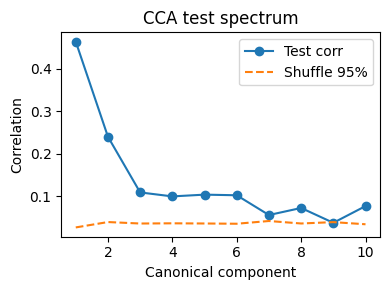

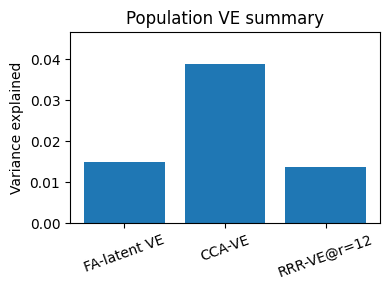

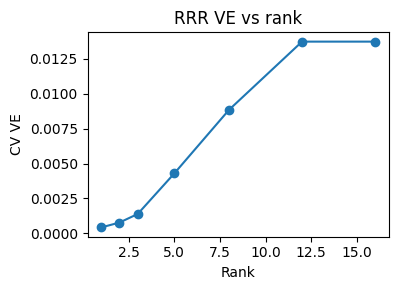

In [120]:
# X = observed (samples × neurons)
# X_hat = predictions (same shape)
# trial_ids = your per-row trial/segment ids
res = population_latent_benchmark(X, X_hat, trial_ids,
                                  n_splits=5,
                                  fa_factors=8,
                                  cca_components=10,
                                  rrr_ranks=(1,2,3,5,8,12,16),
                                  shuffle_reps=100,
                                  rng=0)

print('FA-latent VE (mean±sd):', res.fa_ve_mean, res.fa_ve_std)
print('CCA-VE (mean±sd):      ', res.cca_ve_mean, res.cca_ve_std)
print('RRR best rank:', res.rrr_best_rank)
print('RRR VE by rank:', res.rrr_ve_by_rank)

# show or save figures
for name, fig in res.plots.items():
    fig.show()           # or fig.savefig(f'{name}.png', dpi=200, bbox_inches='tight')


## CCA latent

/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_92060/1959056748.py:113: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sems  = gb.apply(lambda g: pd.Series({
/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_92060/1959056748.py:197: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # or fig.savefig(f'shared_manifold_{i}.png', dpi=200, bbox_inches='tight')


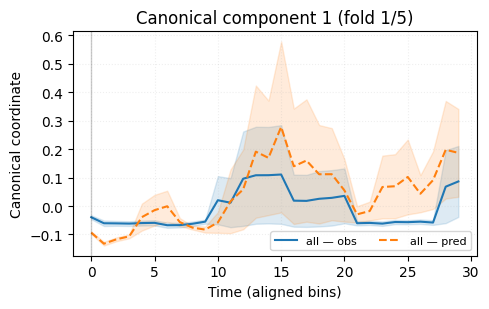

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import GroupKFold

def _zscore(A, eps=1e-12):
    mu = np.nanmean(A, axis=0, keepdims=True)
    sd = np.nanstd(A, axis=0, keepdims=True)
    sd = np.where(sd < eps, 1.0, sd)
    return (A - mu) / sd, mu, sd

def _sem(a, axis=0):
    a = np.asarray(a, float)
    n = np.sum(np.isfinite(a), axis=axis)
    n = np.maximum(n, 1)
    return np.nanstd(a, axis=axis) / np.sqrt(n)

def _smooth_1d(x, k=1):
    if k <= 1: 
        return x
    k = int(k)
    kern = np.ones(k) / k
    return np.convolve(x, kern, mode='same')

def visualize_shared_manifold(
    X, Y, trial_ids, time_idx, cond=None, *,
    n_components=3,
    n_splits=5,
    which_fold=0,            # pick which fold to visualize
    standardize=True,
    smooth_bins=1,           # boxcar smoothing across time for the mean curves
    colors=('C0','C1'),      # (observed, predicted)
    show_phase_plane=True
):
    """
    Fit CCA on TRAIN trials, project TEST trials into canonical space, and plot
    observed vs predicted trajectories (mean±SEM) over time for the first components.

    Parameters
    ----------
    X, Y : arrays (samples × neurons), same shape
    trial_ids : array (samples,)
    time_idx : array (samples,) time within aligned window (e.g., -1.5..+1.5s or bin index)
    cond : optional array-like (samples,), categorical condition label per sample
    n_components : # of canonical components to visualize
    n_splits : GroupKFold splits by trial_ids
    which_fold : index of fold to visualize (0..n_splits-1)
    standardize : z-score each view prior to CCA
    smooth_bins : boxcar width for smoothing mean curves (in bins)
    colors : tuple for (observed, predicted) lines
    show_phase_plane : also plot Comp1 vs Comp2 phase-plane (obs vs pred)
    """
    X = np.asarray(X, float)
    Y = np.asarray(Y, float)
    assert X.shape == Y.shape, "X and Y must have same shape"

    # group-wise split by trials
    trial_ids = np.asarray(trial_ids)
    time_idx = np.asarray(time_idx)
    if cond is None:
        cond = np.array(['all'] * len(time_idx))
    else:
        cond = np.asarray(cond)

    gkf = GroupKFold(n_splits=n_splits)
    splits = list(gkf.split(X, groups=trial_ids))
    tr_idx, te_idx = splits[which_fold]

    Xtr, Ytr = X[tr_idx], Y[tr_idx]
    Xte, Yte = X[te_idx], Y[te_idx]
    trial_te = trial_ids[te_idx]
    time_te  = time_idx[te_idx]
    cond_te  = cond[te_idx]

    # standardize each view
    if standardize:
        Xtr, mux, sdx = _zscore(Xtr)
        Ytr, muy, sdy = _zscore(Ytr)
        Xte = (Xte - mux) / sdx
        Yte = (Yte - muy) / sdy

    # fit CCA on TRAIN only
    k = int(n_components)
    cca = CCA(n_components=k, max_iter=1000)
    Xc_tr, Yc_tr = cca.fit_transform(Xtr, Ytr)
    Xc_te, Yc_te = cca.transform(Xte, Yte)

    # package canonical coordinates for TEST into a tidy DataFrame
    dfs = []
    for view_name, Z in [('obs', Xc_te), ('pred', Yc_te)]:
        df = pd.DataFrame({
            'trial': trial_te,
            'time': time_te,
            'cond': cond_te,
        })
        for i in range(k):
            df[f'can{i+1}'] = Z[:, i]
        df['view'] = view_name
        dfs.append(df)
    df_all = pd.concat(dfs, axis=0, ignore_index=True)

    # aggregate mean ± SEM over trials at each time, by condition & view
    # we align on time bins; ensure numeric sorting
    df_all = df_all.sort_values(['cond', 'view', 'time'])
    results = {}
    for c in np.unique(cond_te):
        results[c] = {}
        dsub = df_all[df_all['cond'] == c]
        # group by time & view, compute mean/sem per component
        gb = dsub.groupby(['view', 'time'])
        means = gb.mean(numeric_only=True)
        sems  = gb.apply(lambda g: pd.Series({
            **{f'can{i+1}': _sem(g[f'can{i+1}'].values) for i in range(k)}
        }))
        # pivot to have time index, separate views
        means = means.reset_index().pivot(index='time', columns='view', values=[f'can{i+1}' for i in range(k)])
        sems  = sems.reset_index().pivot(index='time', columns='view', values=[f'can{i+1}' for i in range(k)])
        # sort by time
        means = means.sort_index()
        sems  = sems.sort_index()
        results[c]['mean'] = means
        results[c]['sem']  = sems

    # --- plotting ---
    figs = []
    # 1) Trajectories for each canonical component
    for i in range(k):
        fig = plt.figure(figsize=(5, 3.2))
        ax = plt.gca()
        for j, c in enumerate(results.keys()):
            means = results[c]['mean'][(f'can{i+1}',)]
            sems  = results[c]['sem'][(f'can{i+1}',)]
            for view_idx, view in enumerate(['obs','pred']):
                y = means[view].values
                s = sems[view].values
                if smooth_bins > 1:
                    y = _smooth_1d(y, smooth_bins)
                    s = _smooth_1d(s, smooth_bins)
                t = means.index.values
                ax.plot(t, y, label=f'{c} — {view}', 
                        linestyle='-' if view=='obs' else '--',
                        color=colors[view_idx])
                ax.fill_between(t, y - s, y + s, alpha=0.15, color=colors[view_idx])
        ax.set_title(f'Canonical component {i+1} (fold {which_fold+1}/{n_splits})')
        ax.set_xlabel('Time (aligned bins)')
        ax.set_ylabel('Canonical coordinate')
        ax.legend(ncol=2, fontsize=8)
        ax.axvline(0, color='k', linewidth=1, alpha=0.2)
        ax.grid(alpha=0.2, linestyle=':')
        plt.tight_layout()
        figs.append(fig)

    # 2) Phase-plane plot (Comp1 vs Comp2)
    if show_phase_plane and k >= 2:
        fig = plt.figure(figsize=(4, 4))
        ax = plt.gca()
        for j, c in enumerate(results.keys()):
            m1 = results[c]['mean'][('can1',)]
            m2 = results[c]['mean'][('can2',)]
            t = m1.index.values
            for view_idx, view in enumerate(['obs','pred']):
                x = m1[view].values
                y = m2[view].values
                if smooth_bins > 1:
                    x = _smooth_1d(x, smooth_bins)
                    y = _smooth_1d(y, smooth_bins)
                ax.plot(x, y, label=f'{c} — {view}',
                        linestyle='-' if view=='obs' else '--',
                        color=colors[view_idx])
                # mark time zero if present
                if 0 in t:
                    idx0 = np.where(t==0)[0]
                    if len(idx0): 
                        ax.scatter(x[idx0[0]], y[idx0[0]], s=30, color=colors[view_idx])
        ax.set_xlabel('Can1')
        ax.set_ylabel('Can2')
        ax.set_title(f'Phase plane (fold {which_fold+1}/{n_splits})')
        ax.legend(ncol=2, fontsize=8)
        ax.grid(alpha=0.2, linestyle=':')
        plt.tight_layout()
        figs.append(fig)

    return {'figs': figs, 'cca': cca}

# X, X_hat: (samples, neurons)
# trial_ids: trial/segment identifier per row (for GroupKFold)
# time_idx: bin index (e.g., -30..+30) or seconds relative to event
# cond: optional labels (e.g., visibility state or stop outcome)
out = visualize_shared_manifold(
    X, X_hat, trial_ids, data['new_bin'], cond=None,
    n_components=3, n_splits=5, which_fold=0,
    standardize=True, smooth_bins=3, show_phase_plane=True
)
# Show or save figures:
for i, fig in enumerate(out['figs'], 1):
    fig.show()  # or fig.savefig(f'shared_manifold_{i}.png', dpi=200, bbox_inches='tight')


In [122]:
import numpy as np
from sklearn.cross_decomposition import CCA

def population_ve_cca(X, Y, n_components=10):
    """
    Canonical correlation analysis between observed (X) and predicted (Y).

    Parameters
    ----------
    X : array, shape (samples, neurons)
    Y : array, shape (samples, neurons) -- same shape as X
    n_components : number of canonical pairs to compute

    Returns
    -------
    corrs : array of canonical correlations (length n_components)
    mean_corr : average canonical correlation across components
    """
    X = np.asarray(X, float)
    Y = np.asarray(Y, float)
    assert X.shape == Y.shape, 'X and Y must have same shape'

    cca = CCA(n_components=n_components, max_iter=1000)
    Xc, Yc = cca.fit_transform(X, Y)
    corrs = [np.corrcoef(Xc[:,i], Yc[:,i])[0,1] for i in range(Xc.shape[1])]
    return np.array(corrs), np.mean(corrs)

corrs, mean_corr = population_ve_cca(X, X_hat, n_components=10)
print('Canonical correlations:', corrs)
print('Mean correlation:', mean_corr)

Canonical correlations: [0.53406 0.25229 0.16888 0.14996 0.12655 0.11985 0.09958 0.09482 0.08322
 0.07489]
Mean correlation: 0.17041150834793165


In [123]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

## one-pager

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import GroupKFold

# --- helpers ---
def _zscore(A, eps=1e-12):
    mu = np.nanmean(A, 0, keepdims=True)
    sd = np.nanstd(A, 0, keepdims=True); sd = np.where(sd < eps, 1.0, sd)
    return (A - mu)/sd, mu, sd

def _sem(a, axis=0):
    n = np.sum(np.isfinite(a), axis=axis)
    n = np.maximum(n, 1)
    return np.nanstd(a, axis=axis) / np.sqrt(n)

def _smooth_1d(x, k=1):
    if k <= 1: return x
    k = int(k)
    w = np.ones(k)/k
    return np.convolve(x, w, mode='same')

def cumulative_shared_variance(corrs):
    """Cumulative 'shared signal' (sum of corr^2) normalized to 1."""
    pwr = np.cumsum(np.square(np.asarray(corrs, float)))
    tot = pwr[-1] if pwr[-1] > 0 else 1.0
    return pwr / tot

# --- one-pager assembly ---
def save_one_pager(
    benchmark_result,                # result from population_latent_benchmark(...)
    cca_corr_test_mean, cca_thresh95,
    traj_figs, rrr_rank_curve_fig, ve_summary_fig, cca_spectrum_fig,
    out_path='one_pager.png'
):
    """
    Lay out 3–4 plots into a single page and save.
    Pass the figure objects produced by your benchmark + enhanced manifold.
    """
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    fig = plt.figure(figsize=(12, 8), dpi=200)
    gs = GridSpec(2, 3, figure=fig, height_ratios=[1,1.1])

    # Top-left: CCA spectrum vs shuffle
    ax1 = fig.add_subplot(gs[0,0])
    ax1.imshow(np.zeros((1,1)), visible=False)  # placeholder; we'll draw onto it via the provided fig
    plt.close(cca_spectrum_fig)  # prevent extra window
    # replot quickly:
    x = np.arange(1, len(cca_corr_test_mean)+1)
    ax1.plot(x, cca_corr_test_mean, marker='o', label='Test corr')
    ax1.plot(x, cca_thresh95, ls='--', label='Shuffle 95%')
    ax1.set_title('CCA test spectrum'); ax1.set_xlabel('Component'); ax1.set_ylabel('Corr'); ax1.legend()

    # Top-middle: cumulative shared variance
    ax2 = fig.add_subplot(gs[0,1])
    cum = cumulative_shared_variance(cca_corr_test_mean)
    ax2.plot(x, cum, marker='o'); ax2.set_ylim(0,1.02)
    ax2.set_title('Cumulative shared signal'); ax2.set_xlabel('Component'); ax2.set_ylabel('Cumulative (corr^2)')

    # Top-right: VE summary bars
    ax3 = fig.add_subplot(gs[0,2])
    names = ['FA-latent VE', 'CCA-VE', f'RRR-VE@r={benchmark_result.rrr_best_rank}']
    vals  = [benchmark_result.fa_ve_mean, benchmark_result.cca_ve_mean,
             benchmark_result.rrr_ve_by_rank[benchmark_result.rrr_best_rank]]
    ax3.bar(np.arange(len(names)), vals)
    ax3.set_xticks(np.arange(len(names))); ax3.set_xticklabels(names, rotation=15)
    ax3.set_ylim(0, max(0.01, max(vals)*1.2)); ax3.set_ylabel('Variance explained')
    ax3.set_title('Population VE summary')

    # Bottom: 2 manifold panels (Can1, Can2) + RRR curve
    # Insert the first two trajectory figs by replotting (for simplicity we draw lines again is better, but here we just call .canvas to bitmap)
    ax4 = fig.add_subplot(gs[1,0])
    ax5 = fig.add_subplot(gs[1,1])
    ax6 = fig.add_subplot(gs[1,2])

    # For ax4/ax5, we’ll just draw titles and note to export separate detailed figs;
    # if you prefer, render traj_figs to images and imshow here.

    ax4.set_title('Manifold traj: Can1 (see detailed fig)')
    ax4.axis('off')
    ax5.set_title('Manifold traj: Can2 (see detailed fig)')
    ax5.axis('off')

    # RRR curve (copy from provided fig)
    plt.close(rrr_rank_curve_fig);  # avoid extra window
    # If you kept x,y from your RRR plot, replot here; otherwise leave placeholder:
    ax6.set_title('RRR VE vs rank'); ax6.set_xlabel('Rank'); ax6.set_ylabel('CV VE')

    fig.suptitle('Population latent benchmark — one-pager', fontsize=13)
    fig.tight_layout(rect=[0,0,1,0.96])
    fig.savefig(out_path, dpi=200, bbox_inches='tight')
    return out_path


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import GroupKFold

# --- small helpers ---
def _zscore(A, eps=1e-12):
    mu = np.nanmean(A, axis=0, keepdims=True)
    sd = np.nanstd(A, axis=0, keepdims=True)
    sd = np.where(sd < eps, 1.0, sd)
    return (A - mu)/sd, mu, sd

def _sem(a, axis=0):
    a = np.asarray(a, float)
    n = np.sum(np.isfinite(a), axis=axis)
    n = np.maximum(n, 1)
    return np.nanstd(a, axis=axis)/np.sqrt(n)

def _smooth_1d(x, k=1):
    if k <= 1: return x
    k = int(k)
    w = np.ones(k)/k
    return np.convolve(x, w, mode='same')

def _clip_quantile(y, lo=0.01, hi=0.99):
    if lo is None or hi is None: return y
    ql, qh = np.nanpercentile(y, [lo*100, hi*100])
    return np.clip(y, ql, qh)

def plot_shared_manifold_enhanced(
    X, Y, trial_ids, time_idx, cond=None, *,
    n_components=3, n_splits=5, which_fold=0,
    standardize=True, smooth_bins=1,
    # --- overlays ---
    overlay_mode='separate',        # 'overlay' | 'separate'
    n_trials_overlay=12, alpha_trials=0.22, linewidth_trials=0.7,
    overlay_norm='zscore_to_sem',   # 'none' | 'zscore' | 'zscore_to_sem'
    clip_quantiles=(0.01, 0.99),    # quantile clip for overlays (None to disable)
    # --- y-limit control for MEAN panels ---
    ylimit_mode='mean_sem_3sd',     # 'auto' | 'mean_sem_3sd' | ('fixed', (ymin,ymax))
    # --- colors ---
    cmap_name='viridis', colors=('C0','C1'),
    show_phase_plane=True
):
    """
    Train CCA on train folds; plot test-fold shared-manifold trajectories.

    Panels per canonical component:
      - If overlay_mode='overlay': single panel with mean±SEM + faint single trials.
      - If overlay_mode='separate': two panels: Left=mean±SEM, Right=single trials.
    Also produces a time-colored phase-plane (Can1 vs Can2).
    """
    X = np.asarray(X, float); Y = np.asarray(Y, float)
    assert X.shape == Y.shape, "X and Y must have same shape"
    trial_ids = np.asarray(trial_ids); time_idx = np.asarray(time_idx)
    if cond is None: cond = np.array(['all']*len(time_idx))
    else: cond = np.asarray(cond)

    # Split by trial
    gkf = GroupKFold(n_splits=n_splits)
    splits = list(gkf.split(X, groups=trial_ids))
    tr_idx, te_idx = splits[which_fold]
    Xtr, Ytr = X[tr_idx], Y[tr_idx]
    Xte, Yte = X[te_idx], Y[te_idx]
    trial_te = trial_ids[te_idx]; time_te = time_idx[te_idx]; cond_te = cond[te_idx]

    # Standardize
    if standardize:
        Xtr, mux, sdx = _zscore(Xtr); Xte = (Xte - mux)/sdx
        Ytr, muy, sdy = _zscore(Ytr); Yte = (Yte - muy)/sdy

    # CCA
    k = int(n_components)
    cca = CCA(n_components=k, max_iter=1000)
    cca.fit(Xtr, Ytr)
    Xc_te, Yc_te = cca.transform(Xte, Yte)

    # Tidy DF (test only)
    dfs = []
    for view, Z in [('obs', Xc_te), ('pred', Yc_te)]:
        d = pd.DataFrame({'trial': trial_te, 'time': time_te, 'cond': cond_te, 'view': view})
        for i in range(k): d[f'can{i+1}'] = Z[:, i]
        dfs.append(d)
    df = pd.concat(dfs, ignore_index=True)

    figs = []

    # === Per-component panels ===
    for ic in range(k):
        comp_col = f'can{ic+1}'

        # mean/sem per time
        dmean = (df.groupby(['view','time'])
                   .mean(numeric_only=True)[[comp_col]]
                   .rename(columns={comp_col:'mean'})
                 ).reset_index()
        dsem  = (df.groupby(['view','time'])
                   .apply(lambda g: pd.Series({'sem': _sem(g[comp_col].values)}))
                 ).reset_index()

        # Pivot for plotting
        m_obs = dmean[dmean.view=='obs'][['time','mean']].sort_values('time').values
        m_pred= dmean[dmean.view=='pred'][['time','mean']].sort_values('time').values
        s_obs = dsem [dsem .view=='obs'][['time','sem']].sort_values('time').values
        s_pred= dsem [dsem .view=='pred'][['time','sem']].sort_values('time').values

        t = m_obs[:,0]
        mu_obs, mu_pred = _smooth_1d(m_obs[:,1], smooth_bins), _smooth_1d(m_pred[:,1], smooth_bins)
        se_obs, se_pred = _smooth_1d(s_obs[:,1], smooth_bins), _smooth_1d(s_pred[:,1], smooth_bins)

        if overlay_mode == 'separate':
            fig, (ax_mean, ax_trials) = plt.subplots(1, 2, figsize=(9, 3.2), sharey=False)
        else:  # overlay
            fig, ax_mean = plt.subplots(1, 1, figsize=(5.4, 3.2))
            ax_trials = ax_mean

        # --- MEAN ± SEM panel ---
        ax_mean.plot(t, mu_obs, color=colors[0], label='all — obs', linestyle='-')
        ax_mean.fill_between(t, mu_obs-se_obs, mu_obs+se_obs, color=colors[0], alpha=0.18)
        ax_mean.plot(t, mu_pred, color=colors[1], label='all — pred', linestyle='--')
        ax_mean.fill_between(t, mu_pred-se_pred, mu_pred+se_pred, color=colors[1], alpha=0.18)
        ax_mean.axvline(0, color='k', lw=1, alpha=0.25)
        ax_mean.grid(alpha=0.2, ls=':')
        ax_mean.set_title(f'Canonical component {ic+1} (fold {which_fold+1}/{n_splits})')
        ax_mean.set_xlabel('Time (aligned bins)')
        ax_mean.set_ylabel('Canonical coordinate')
        ax_mean.legend(ncol=2, fontsize=8)

        # y-limit logic for MEAN panel
        if isinstance(ylimit_mode, tuple) and len(ylimit_mode) == 2 and ylimit_mode[0] == 'fixed':
            ax_mean.set_ylim(*ylimit_mode[1])
        elif ylimit_mode == 'mean_sem_3sd':
            # robust limits from mean ± (3 * pooled SEM)
            pooled = np.maximum(se_obs, 0) + np.maximum(se_pred, 0)
            lo = np.nanmin([mu_obs - 3*pooled, mu_pred - 3*pooled])
            hi = np.nanmax([mu_obs + 3*pooled, mu_pred + 3*pooled])
            pad = 0.05*(hi - lo + 1e-9)
            ax_mean.set_ylim(lo - pad, hi + pad)
        else:
            pass  # 'auto'

        # --- SINGLE-TRIAL panel (or overlays) ---
        # pick subset of trials for speed/clarity
        rng = np.random.default_rng(0)
        all_trials = df['trial'].unique()
        pick = all_trials if len(all_trials) <= n_trials_overlay else rng.choice(all_trials, n_trials_overlay, replace=False)

        for view, col in [('obs','C0'), ('pred','C1')]:
            for tr in pick:
                one = df[(df.trial==tr) & (df.view==view)][['time', comp_col]].sort_values('time').values
                tt, yy = one[:,0], one[:,1].copy()
                # quantile clip to tame rare spikes
                if clip_quantiles is not None:
                    yy = _clip_quantile(yy, *clip_quantiles)
                # per-trial normalization
                if overlay_norm in ('zscore', 'zscore_to_sem'):
                    sd = np.nanstd(yy); sd = 1.0 if sd < 1e-12 else sd
                    yy = (yy - np.nanmean(yy)) / sd
                    if overlay_norm == 'zscore_to_sem':
                        # rescale to sit inside the mean ± SEM band of the corresponding view
                        if view == 'obs':
                            yy = yy * np.nanmean(se_obs)
                        else:
                            yy = yy * np.nanmean(se_pred)
                yy = _smooth_1d(yy, smooth_bins)
                ax_trials.plot(tt, yy, color=col, alpha=alpha_trials, lw=linewidth_trials)

        if overlay_mode == 'separate':
            ax_trials.set_title('Single trials')
            ax_trials.set_xlabel('Time (aligned bins)')
            ax_trials.set_ylabel('Canonical coordinate (scaled)')
            ax_trials.grid(alpha=0.2, ls=':')
            ax_trials.axvline(0, color='k', lw=1, alpha=0.25)

        plt.tight_layout()
        figs.append(fig)

    # === Phase-plane (Can1 vs Can2), time-colored ===
    if show_phase_plane and k >= 2:
        fig = plt.figure(figsize=(4.4, 4.4)); ax = plt.gca()
        norm = Normalize(vmin=np.min(time_te), vmax=np.max(time_te))
        cmap = cm.get_cmap(cmap_name)
        # mean trajectories only (clean)
        for view, ls, base_color in [('obs','-','C0'), ('pred','--','C1')]:
            sub = df[df['view']==view]
            m1 = (sub.groupby('time')['can1'].mean()).sort_index()
            m2 = (sub.groupby('time')['can2'].mean()).sort_index()
            t  = m1.index.values
            x  = _smooth_1d(m1.values, smooth_bins)
            y  = _smooth_1d(m2.values, smooth_bins)
            for i in range(len(t)-1):
                ax.plot(x[i:i+2], y[i:i+2], ls=ls, color=cmap(norm(t[i])))
            if 0 in t:
                i0 = np.where(t==0)[0][0]
                ax.scatter(x[i0], y[i0], s=30, color=base_color, edgecolor='k', zorder=3)
        sm = cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Time (aligned bins)')
        ax.set_xlabel('Can1'); ax.set_ylabel('Can2')
        ax.set_title(f'Phase plane (fold {which_fold+1}/{n_splits})')
        ax.grid(alpha=0.2, ls=':')
        plt.tight_layout()
        figs.append(fig)

    return {'figs': figs, 'cca': cca, 'df': df}


In [ ]:
time_idx = data['new_bin']
condition_labels = None

In [ ]:
# 1) Run your benchmark (from earlier code) to get VE bars/CCA spectrum/RRR curve:
res = population_latent_benchmark(X, X_hat, trial_ids,
                                  n_splits=5, fa_factors=8, cca_components=10,
                                  rrr_ranks=(1,2,3,5,8,12,16), shuffle_reps=100)


/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_5636/4251872128.py:101: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({'sem': _sem(g[comp_col].values)}))
/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_5636/4251872128.py:101: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({'sem': _sem(g[comp_col].values)}))
/var/folders/81/249hbjx960s5t_1dxgdx

Saved: one_pager.png


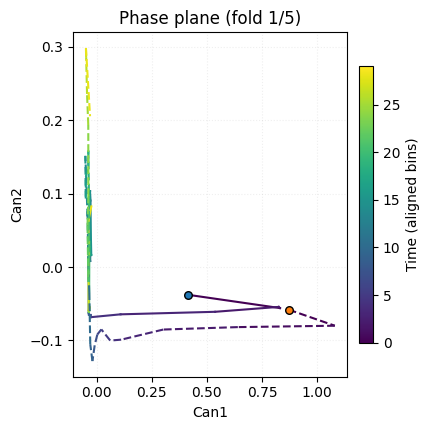

In [ ]:

# 2) Make enhanced shared-manifold plots for a fold (and reuse the fitted CCA df if needed):
traj_figs, cca_obj, df_can = plot_shared_manifold_enhanced(
    X, X_hat, trial_ids, time_idx, cond=condition_labels,
    n_components=3, n_splits=5, which_fold=0,
    smooth_bins=3, n_trials_overlay=40, show_phase_plane=True
)

# 3) Save a one-pager (PNG or PDF)
out_path = save_one_pager(
    benchmark_result=res,
    cca_corr_test_mean=res.cca_corr_test_mean,
    cca_thresh95=res.cca_corr_thresh95,
    traj_figs=traj_figs,
    rrr_rank_curve_fig=res.plots['rrr_curve'],
    ve_summary_fig=res.plots['ve_summary'],
    cca_spectrum_fig=res.plots['cca_spectrum'],
    out_path='one_pager.png'  # or 'one_pager.pdf'
)
print('Saved:', out_path)


## Plot spikes

In [ ]:
reload(plot_spikes)

<module 'neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_glm.glm_plotting.plot_spikes' from '/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/topic_based_neural_analysis/stop_event_analysis/stop_glm/glm_plotting/plot_spikes.py'>

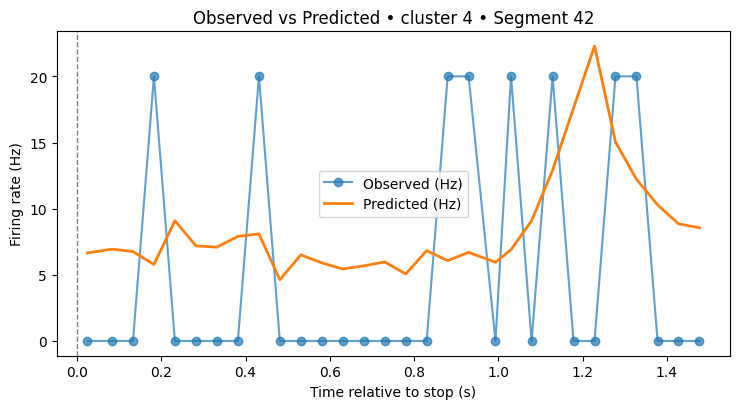

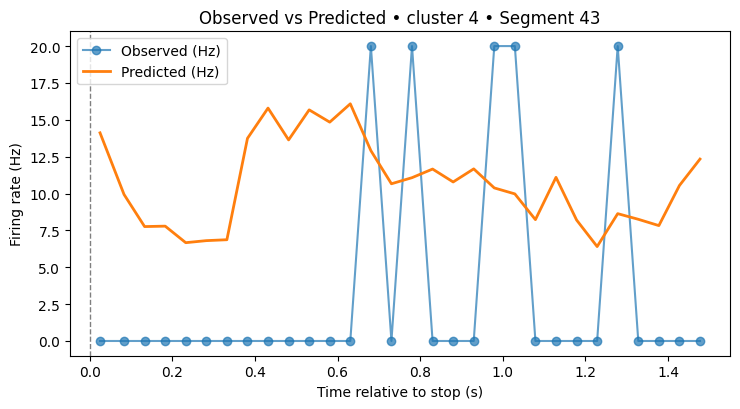

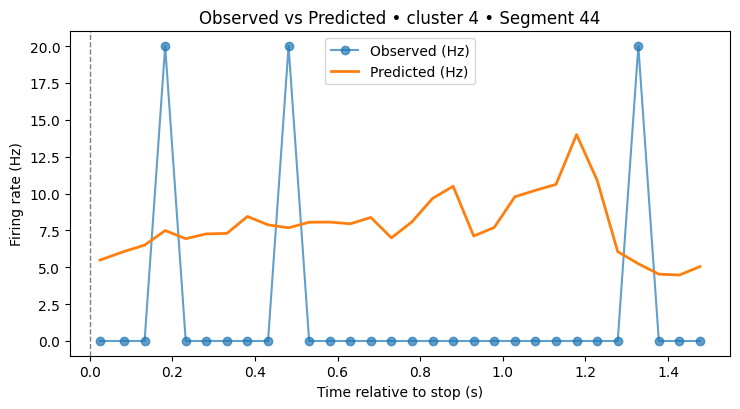

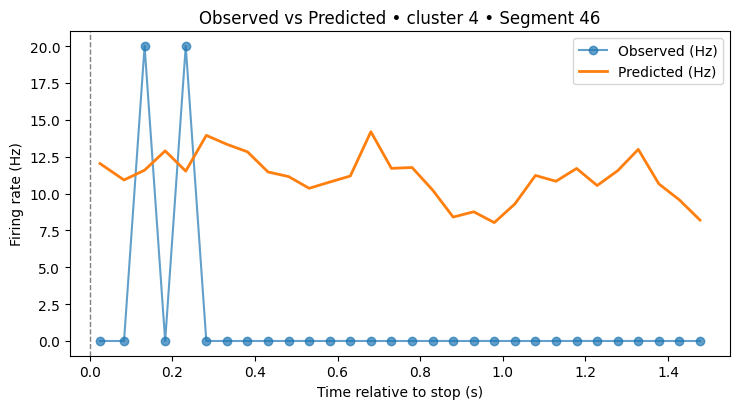

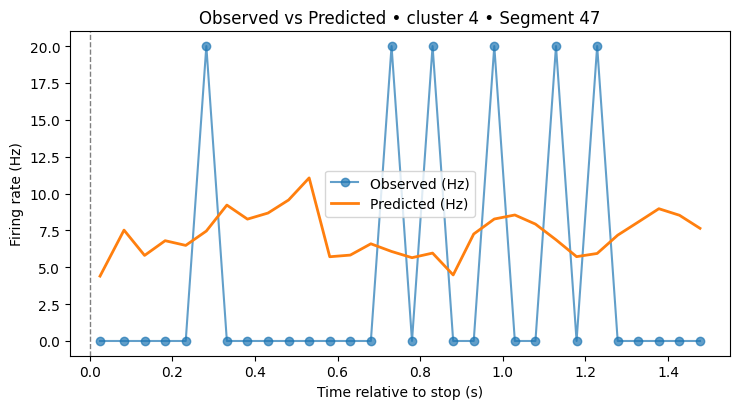

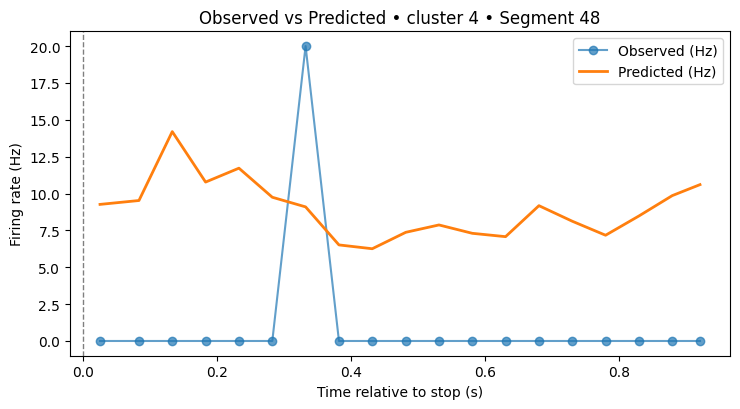

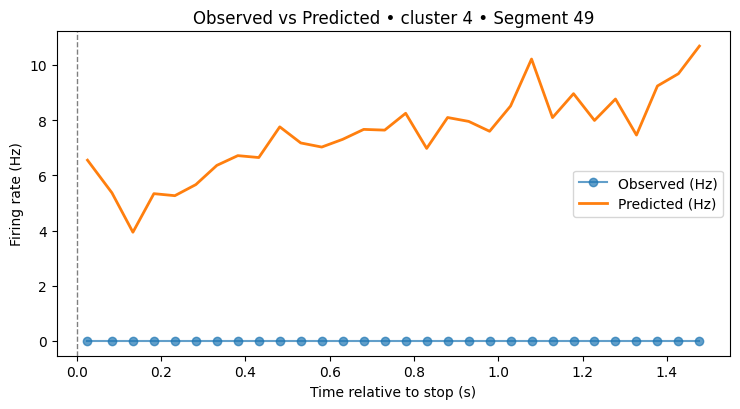

In [ ]:
cluster_idx = 4

rebinned_y_var['rel_time'] = rebinned_y_var['time'] - rebinned_y_var['new_seg_start_time']

for event_id in range(40, 52):
    # If your GLM used offset_log = np.log(exposure_s), you can omit exposure_s:
    plot_spikes.plot_observed_vs_predicted_event(
        binned_feats_sc=df_X,
        binned_spikes=df_Y,
        meta_used=rebinned_y_var,
        offset_log=offset_log,
        model_res=report['results'][cluster_idx],   # GLM for cluster 0
        cluster_idx=cluster_idx,
        seg_id=event_id,
        time_col='rel_time',
        seg_col='new_segment'
    )
plt.show()

## tuning curve

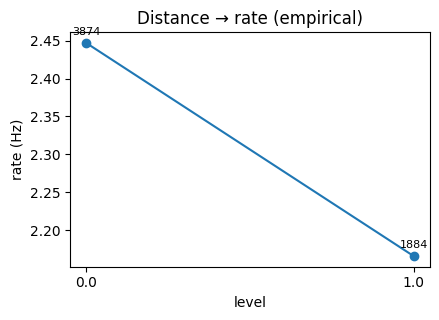

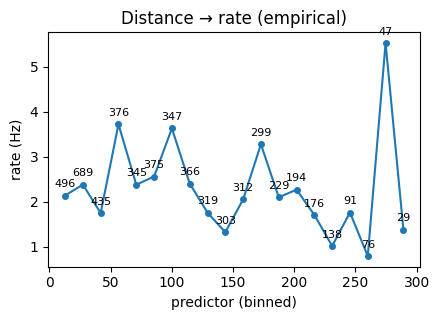

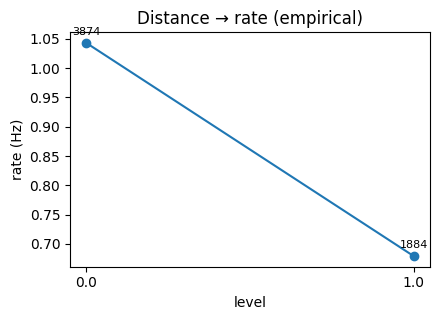

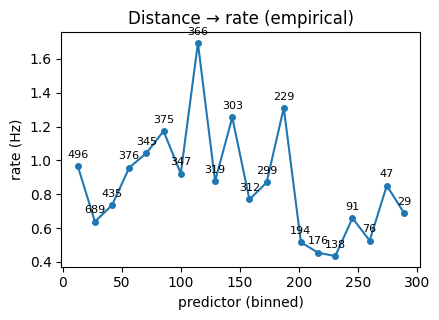

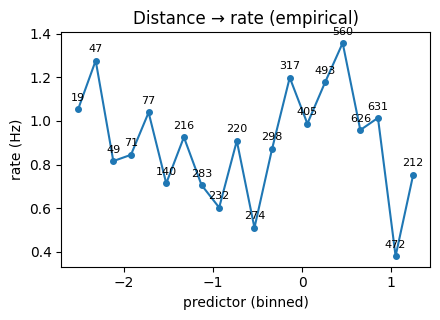

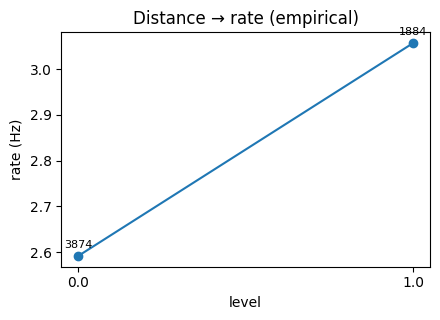

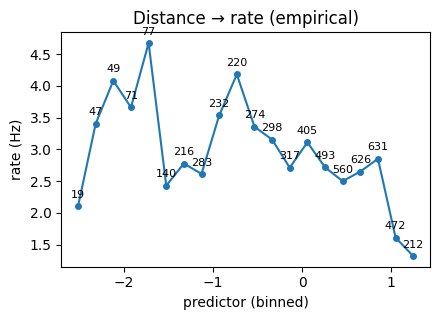

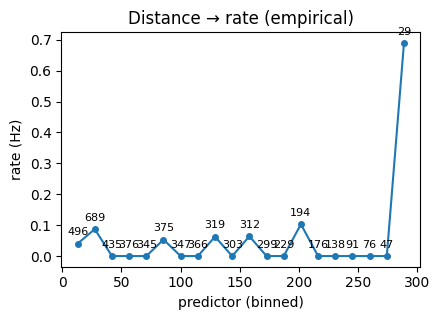

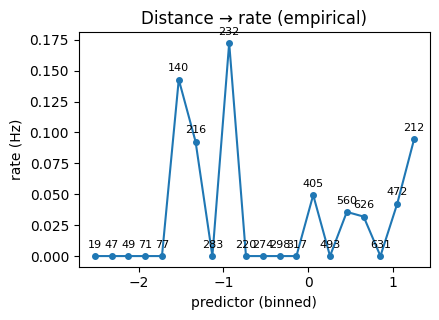

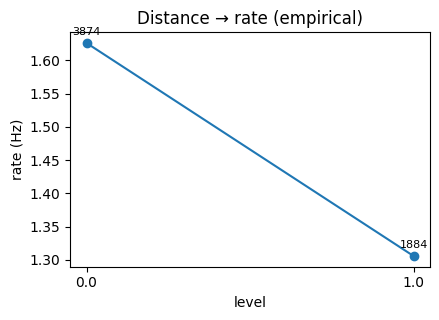

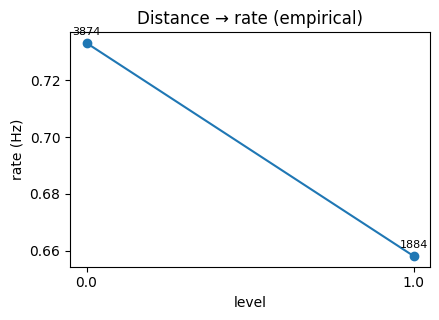

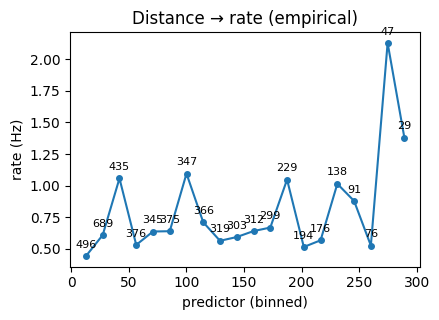

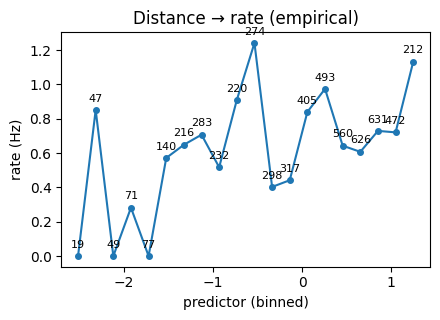

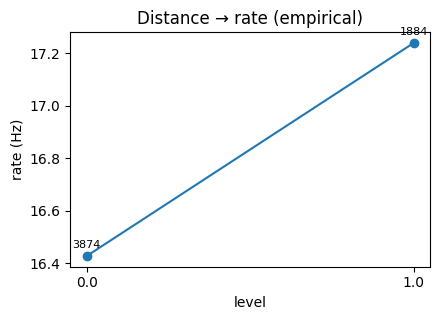

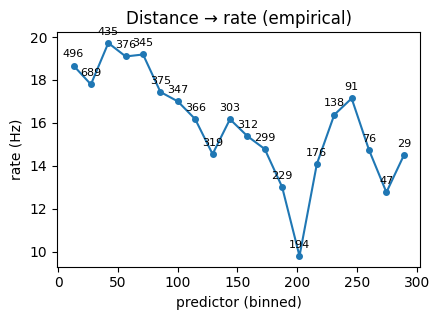

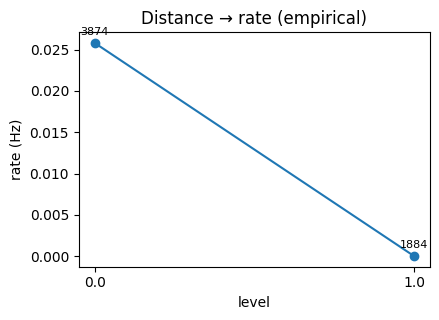

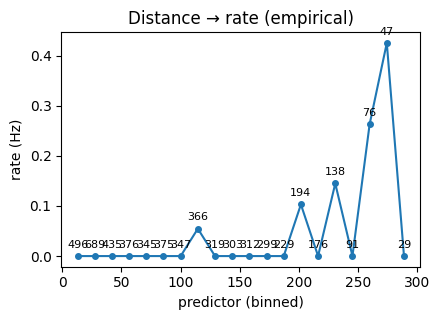

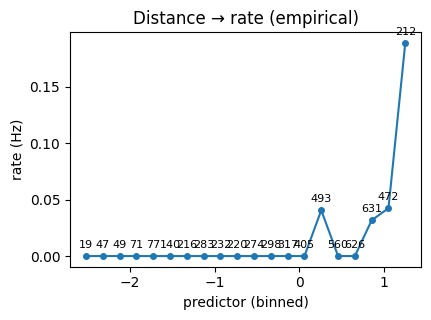

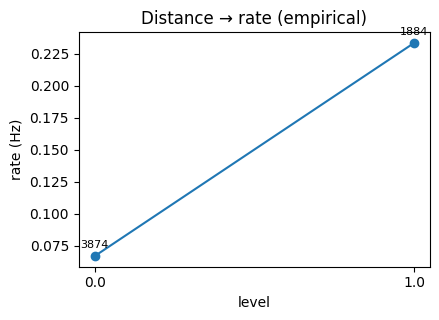

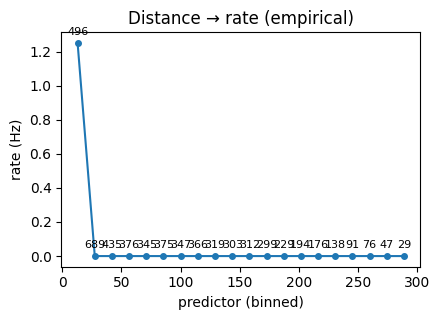

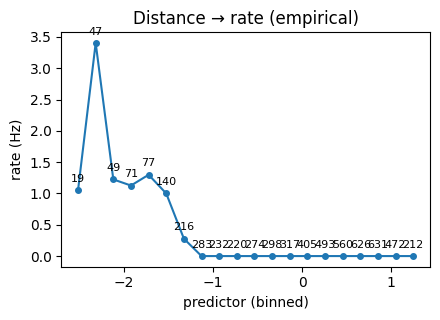

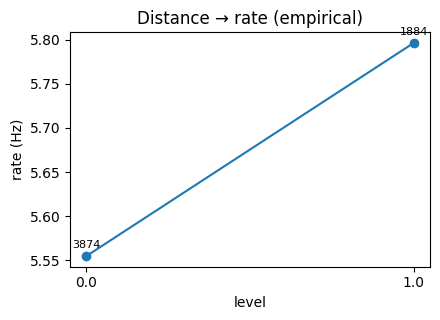

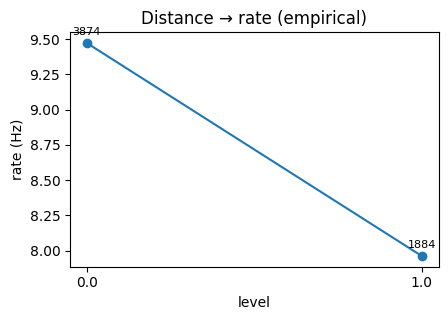

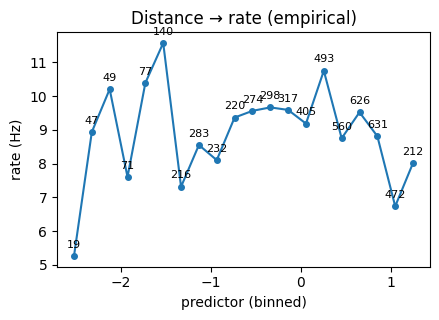

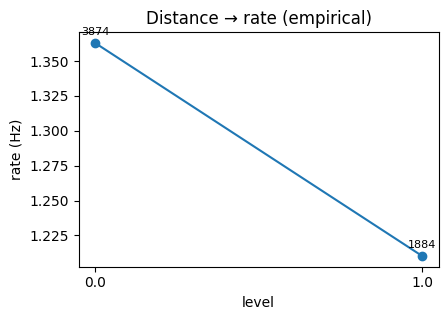

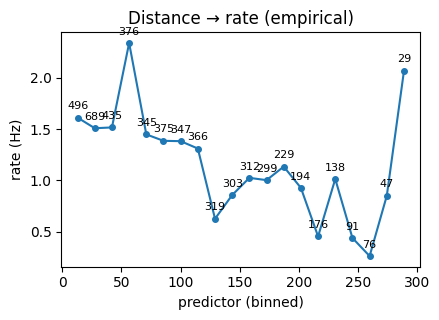

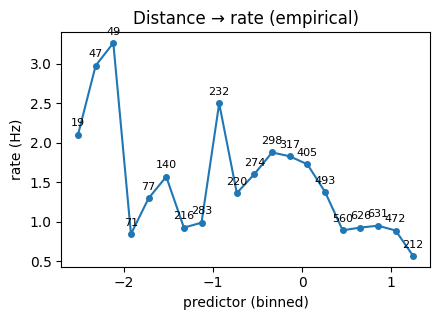

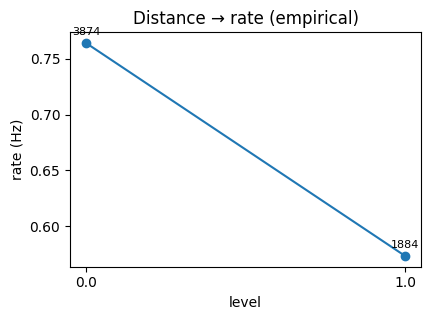

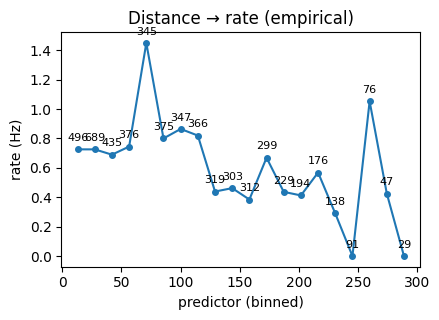

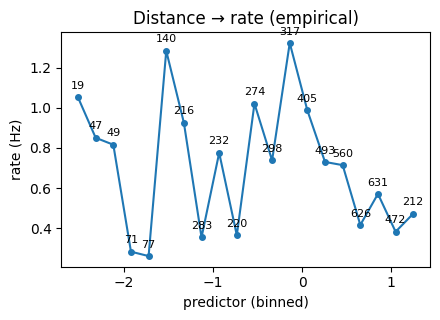

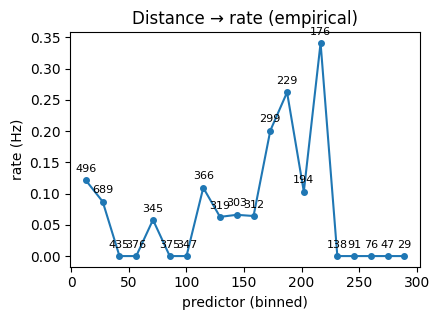

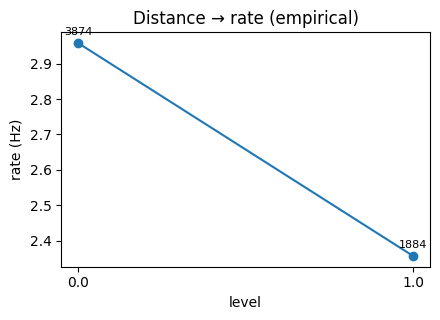

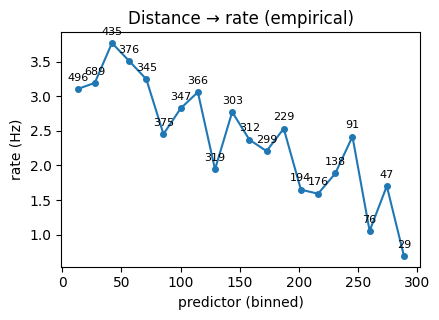

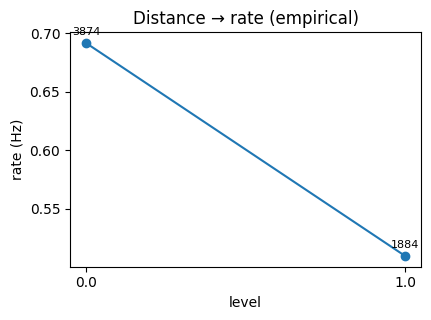

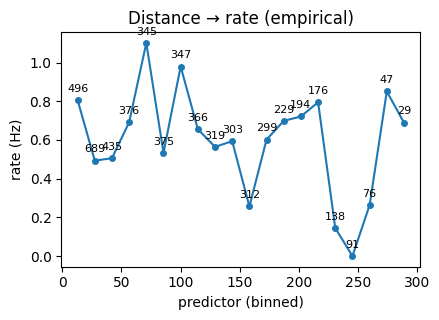

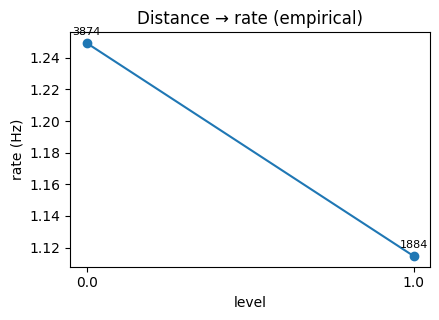

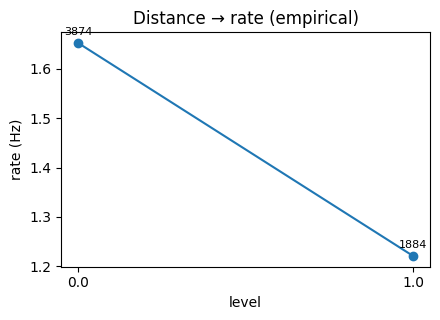

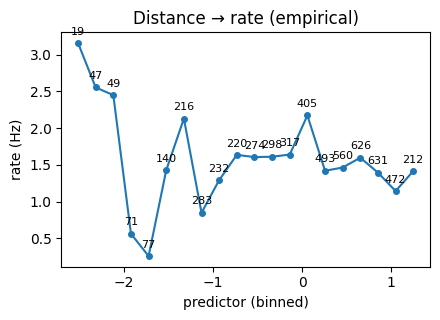

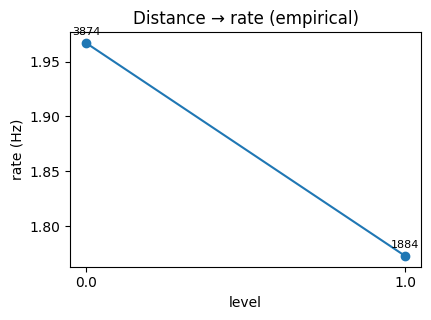

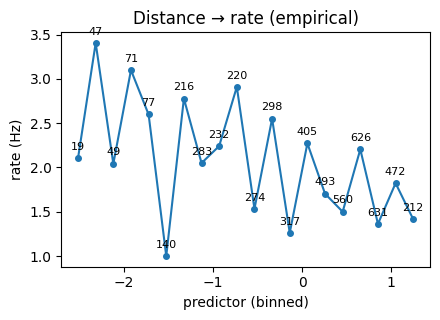

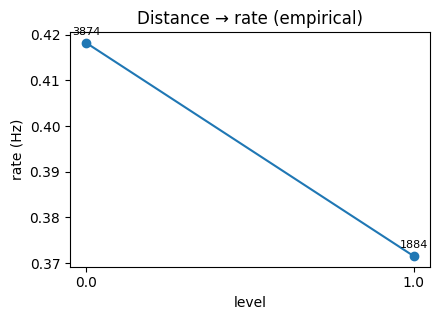

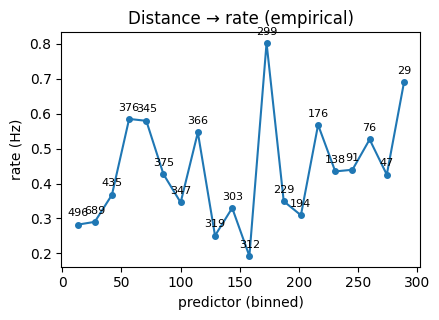

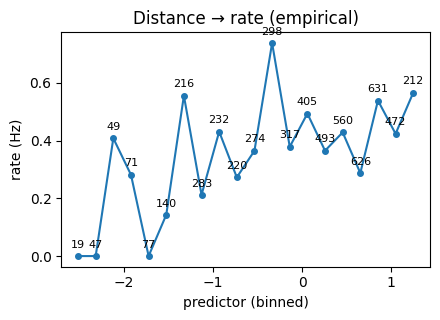

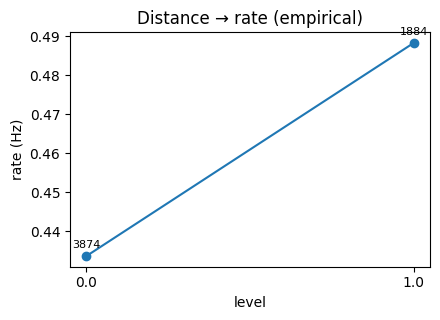

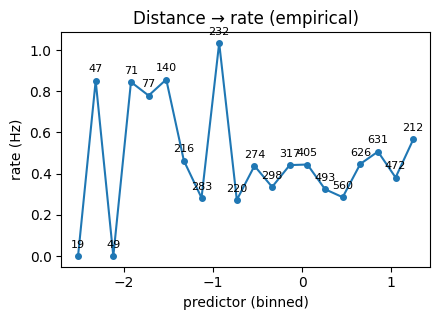

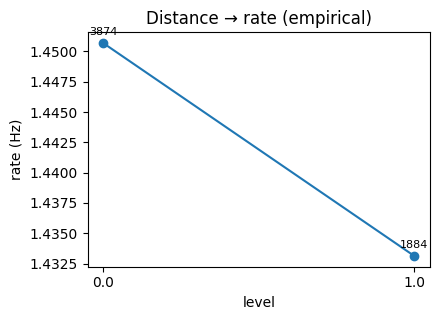

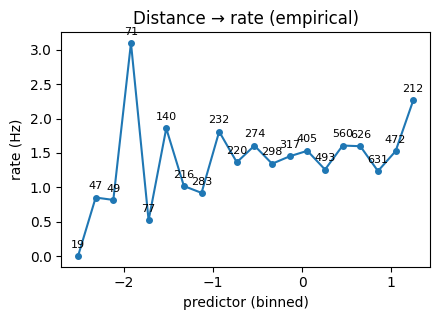

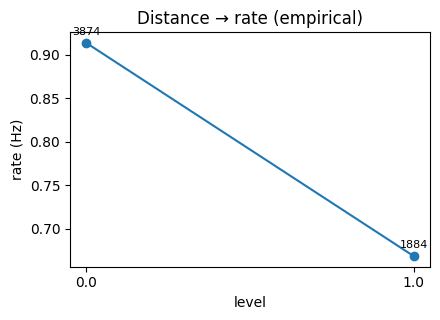

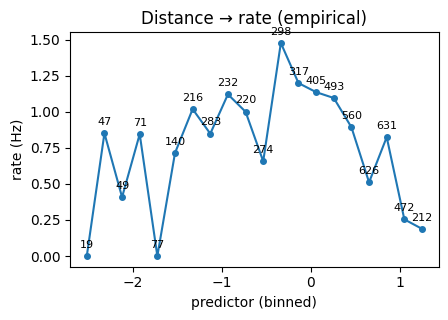

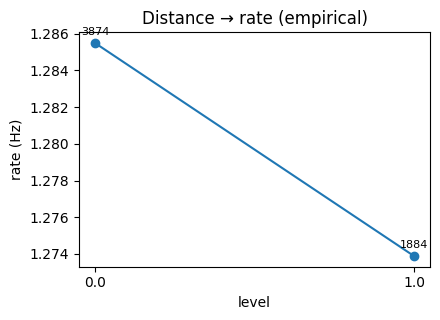

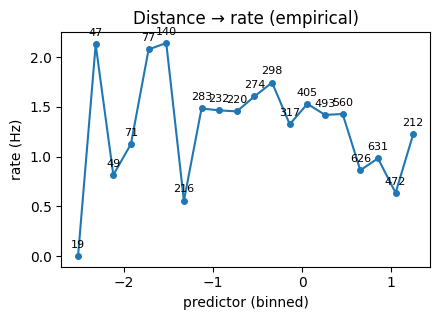

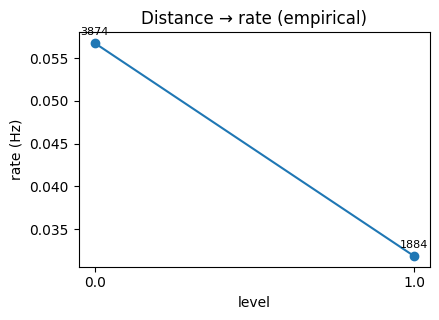

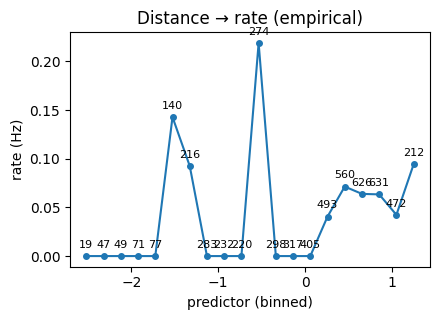

In [ ]:
reload(plot_tuning_func)



for cluster_id in df_Y.columns:
    
    print('==========================================')
    model_res = report['results'][cluster_id]
    
    for var in ['nxt_in_memory', 'cur_ff_distance', 'log_cur_ff_distance']:

        exposure_s = np.exp(offset_log)
        # make empirical curve
        tc_emp = plot_tuning_func.empirical_tuning_curve(
            binned_spikes=df_Y[cluster_id].to_numpy(),
            predictor_vals=df_X[var].to_numpy(),
            exposure_s=exposure_s,
            nbins=20
        )

        # just empirical
        plot_tuning_func.plot_tuning_with_ci(tc_emp, title='Distance → rate (empirical)',
                    kind='line', ci_style='band', show_counts=True)
        plt.show()


        # # make GLM curve
        # tc_glm = plot_tuning_func.glm_tuning_curve(
        #     model_res, df_X,
        #     var=var,
        #     offset_log=offset_log,
        #     average='marginal',
        #     weights=exposure_s,                 # time-weighted average rate (recommended)
        #     return_ci=True
        # )

        # # overlay
        # plot_tuning_func.overlay_tuning_curves(tc_emp, tc_glm, xcol=var,
        #                     title=f'Unit {cluster_id}: {var} tuning')


In [ ]:
tc_emp = plot_tuning_func.empirical_tuning_curve(binned_spikes=df_Y[cluster_id].to_numpy(),
            predictor_vals=df_X[var].to_numpy(),
            exposure_s=exposure_s,
            nbins=20)
plot_tuning_func.plot_tuning_with_ci(tc_emp, title='Distance → rate (empirical)',
                    kind='line', ci_style='band', show_counts=True)

# # for discrete variables
# df_emp = empirical_tuning_curve(spikes, cur_visible.astype(int), bin_durations)
# plot_tuning_with_ci(df_emp, title='Visibility → rate (empirical)',
#                     kind='bar', ci_style='errorbar', show_counts=True)


# try forward selection

In [ ]:
list(meta['groups'].keys())

['cur_vis',
 'nxt_vis',
 'cur_in_memory',
 'nxt_in_memory',
 'cur_vis_on',
 'cur_vis_off',
 'any_ff_visible_on',
 'any_ff_visible_off',
 'cur_ff_distance',
 'nxt_ff_distance',
 'cur_ff_rel_x',
 'nxt_ff_rel_x',
 'speed',
 'ang_speed',
 'curv_of_traj',
 'cur_ff_angle',
 'nxt_ff_angle',
 'any_ff_in_memory',
 'log_cur_ff_distance',
 'time_since_target_last_seen',
 'time_since_last_capture',
 'cum_dist_seen_log1p',
 'eye_speed_log1p',
 'gaze_mky_view_x_z',
 'gaze_mky_view_y_z',
 'gaze_mky_view_x_z*gaze_mky_view_y_z',
 'RDz_odd',
 'RDz_mag',
 'RDy_odd',
 'RDy_mag',
 'LDz_odd',
 'LDz_mag',
 'LDy_odd',
 'LDy_mag',
 'speed_log1p',
 'speed_z',
 'accel_odd',
 'accel_mag',
 'accel_mag_spline',
 'ang_accel_odd',
 'ang_accel_mag',
 'ang_accel_mag_spline']

In [ ]:
meta['groups']

{'cur_vis': ['cur_vis'],
 'nxt_vis': ['nxt_vis'],
 'cur_in_memory': ['cur_in_memory'],
 'nxt_in_memory': ['nxt_in_memory'],
 'cur_vis_on': ['cur_vis_on:b0:0', 'cur_vis_on:b0:1', 'cur_vis_on:b0:2'],
 'cur_vis_off': ['cur_vis_off:b0:0', 'cur_vis_off:b0:1', 'cur_vis_off:b0:2'],
 'any_ff_visible_on': ['any_ff_visible_on:b0:0',
  'any_ff_visible_on:b0:1',
  'any_ff_visible_on:b0:2'],
 'any_ff_visible_off': ['any_ff_visible_off:b0:0',
  'any_ff_visible_off:b0:1',
  'any_ff_visible_off:b0:2'],
 'cur_ff_distance': ['cur_ff_distance:s0',
  'cur_ff_distance:s1',
  'cur_ff_distance:s2',
  'cur_ff_distance'],
 'nxt_ff_distance': ['nxt_ff_distance:s0',
  'nxt_ff_distance:s1',
  'nxt_ff_distance:s2'],
 'cur_ff_rel_x': ['cur_ff_rel_x:s0', 'cur_ff_rel_x:s1', 'cur_ff_rel_x:s2'],
 'nxt_ff_rel_x': ['nxt_ff_rel_x:s0', 'nxt_ff_rel_x:s1', 'nxt_ff_rel_x:s2'],
 'speed': ['speed:s0', 'speed:s1', 'speed:s2'],
 'ang_speed': ['ang_speed:s0', 'ang_speed:s1', 'ang_speed:s2'],
 'curv_of_traj': ['curv_of_traj:s0', 'c

In [ ]:
design_df.columns

Index(['const', 'cur_vis', 'nxt_vis', 'cur_in_memory', 'nxt_in_memory',
       'cur_vis_on:b0:0', 'cur_vis_on:b0:1', 'cur_vis_on:b0:2',
       'cur_vis_off:b0:0', 'cur_vis_off:b0:1', 'cur_vis_off:b0:2',
       'any_ff_visible_on:b0:0', 'any_ff_visible_on:b0:1',
       'any_ff_visible_on:b0:2', 'any_ff_visible_off:b0:0',
       'any_ff_visible_off:b0:1', 'any_ff_visible_off:b0:2',
       'cur_ff_distance:s0', 'cur_ff_distance:s1', 'cur_ff_distance:s2',
       'nxt_ff_distance:s0', 'nxt_ff_distance:s1', 'nxt_ff_distance:s2',
       'cur_ff_rel_x:s0', 'cur_ff_rel_x:s1', 'cur_ff_rel_x:s2',
       'nxt_ff_rel_x:s0', 'nxt_ff_rel_x:s1', 'nxt_ff_rel_x:s2', 'speed:s0',
       'speed:s1', 'speed:s2', 'ang_speed:s0', 'ang_speed:s1', 'ang_speed:s2',
       'curv_of_traj:s0', 'curv_of_traj:s1', 'curv_of_traj:s2',
       'cur_ff_angle:sin1', 'cur_ff_angle:cos1', 'cur_ff_angle:sin2',
       'cur_ff_angle:cos2', 'cur_ff_angle:sin3', 'cur_ff_angle:cos3',
       'nxt_ff_angle:sin1', 'nxt_ff_angle:cos1',

In [ ]:
from neural_data_analysis.neural_analysis_tools.glm_tools import forward_selection

In [ ]:
reload(forward_selection)

<module 'neural_data_analysis.neural_analysis_tools.glm_tools.forward_selection' from '/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/glm_tools/forward_selection.py'>

In [ ]:
design_df

const  cur_vis  nxt_vis  cur_in_memory  nxt_in_memory  cur_vis_on:b0:0  \
0    1.00000  1.00000  0.00000        1.00000        0.00000          6.05098   
1    1.00000  1.00000  0.00000        1.00000        0.00000          3.67264   
2    1.00000  1.00000  0.00000        1.00000        0.00000          2.86152   
3    1.00000  1.00000  0.00000        1.00000        0.00000          2.34870   
4    1.00000  1.00000  0.00000        1.00000        0.00000          1.97109   
...      ...      ...      ...            ...            ...              ...   
9334 1.00000  0.00000  0.00000        1.00000        0.00000          0.00000   
9335 1.00000  0.00000  0.00000        1.00000        0.00000          0.00000   
9336 1.00000  0.00000  0.00000        1.00000        0.00000          0.00000   
9337 1.00000  0.00000  0.00000        1.00000        0.00000          0.00000   
9338 1.00000  0.00000  0.00000        1.00000        0.00000          0.00000   

      cur_vis_on:b0:1  cur_vis_on:b0:2  cur_vis_off:b0:0  cur_vis_off:b0:1  \
0             2.62676          0.77130           0.00000           0.00000   
1             3.23692          3.00081           0.00000           0.00000   
2             3.06333          3.17268           0.00000           0.00000   
3             2.92438          3.23632           0.00000           0.00000   
4             2.80978          3.26423           0.00000           0.00000   
...               ...              ...               ...               ...   
9334          0.00000          0.00000           0.00000           0.00000   
9335          0.00000          0.00000           0.00000           0.00000   
9336          0.00000          0.00000           0.00000           0.00000   
9337          0.00000          0.00000           0.00000           0.00000   
9338          0.00000          0.00000           0.00000           0.00000   

      ...  accel_mag_spline:s0  accel_mag_spline:s1  accel_mag_spline:s2  \
0     ...             -0.08562             -0.01682             -0.11042   
1     ...             -0.08562             -0.01690             -0.11434   
2     ...             -0.08562             -0.01693             -0.11673   
3     ...             -0.08562             -0.01669             -0.10527   
4     ...             -0.08562             -0.01386             -0.05160   
...   ...                  ...                  ...                  ...   
9334  ...             -0.08562             -0.01663             -0.10325   
9335  ...             -0.08562             -0.01642             -0.09699   
9336  ...             -0.08562             -0.01694             -0.11795   
9337  ...             -0.08562             -0.01693             -0.11687   
9338  ...             -0.08562             -0.01347             -0.04658   

      accel_mag_spline:s3  ang_accel_odd  ang_accel_mag  \
0                -0.16568        0.13825        0.22566   
1                -0.21406        4.62254        2.23700   
2                -0.25595       -0.63495        0.76339   
3                -0.11901        1.88297        1.48372   
4                 0.09760       -0.24674        0.36693   
...                   ...            ...            ...   
9334             -0.10370       -3.07310        1.88040   
9335             -0.06332       -2.26226        1.62715   
9336             -0.28603       -4.12518        2.13527   
9337             -0.25893       -0.11183        0.18169   
9338              0.10846       -0.00169        0.00000   

      ang_accel_mag_spline:s0  ang_accel_mag_spline:s1  \
0                    -0.06581                  0.00079   
1                    -0.06581                 -0.02806   
2                    -0.06581                 -0.02112   
3                    -0.06581                 -0.02687   
4                    -0.06581                 -0.00972   
...                       ...                      ...   
9334                 -0.06581                 -0.02777   
9335       

In [ ]:
groups = meta['groups']
df_X_full = design_df

# df_X_full.columns is your long Index([...]) from the message
# groups is exactly your dict
# y is spikes, trial_ids from data, offset_log = np.log(exposure_s)

# sensible tiny base: intercept + one robust driver
base_groups = ['log_cur_ff_distance']  # 'const' is already a column in df_X_full; keep it inside a group if you want
if 'const' not in groups:
    # treat the literal 'const' column as its own group
    groups = {'const': ['const'], **groups}
base_groups = ['const', 'log_cur_ff_distance']

# candidates = everything else (you can curate)
candidates = [g for g in groups.keys() if g not in base_groups]

X_star, selected_groups, log_df = forward_selection.forward_block_select(
    df_X_full=df_X_full,
    groups=groups,
    y=y,
    trial_ids=data['new_segment'].to_numpy(),
    offset_log=offset_log,  # or scalar np.log(dt)
    base_groups=base_groups,
    candidate_groups=candidates,
    nfolds=5,
    max_steps=20,
    rng=0
)

print('Selected order:', selected_groups)
print('Final X shape:', X_star.shape)
print(log_df)


Selected order: ['const', 'log_cur_ff_distance', 'LDz_mag', 'speed_z', 'RDy_odd', 'time_since_last_capture', 'ang_accel_mag_spline', 'RDy_mag', 'LDy_mag']
Final X shape: (9339, 12)
   step              added_group  cv_deviance  rel_improve  n_params  \
0     0                     None   1239.32940      0.00000         2   
1     1                  LDz_mag   1186.87461      0.04233         3   
2     2                  speed_z   1176.33545      0.00888         4   
3     3                  RDy_odd   1166.08327      0.00872         5   
4     4  time_since_last_capture   1160.41632      0.00486         6   
5     5     ang_accel_mag_spline   1155.80009      0.00398        10   
6     6                  RDy_mag   1152.62092      0.00275        11   
7     7                  LDy_mag   1148.72741      0.00338        12   

   cond_number  
0      1.07394  
1     11.01206  
2     11.68870  
3     12.09132  
4     16.41638  
5     90.56620  
6    109.40499  
7    128.98535  


In [ ]:
log_df['added_group'].values

array([None, 'LDz_mag', 'speed_z', 'RDy_odd', 'time_since_last_capture',
       'ang_accel_mag_spline', 'RDy_mag', 'LDy_mag'], dtype=object)

In [ ]:
# groups: dict[str, list[str]]
# design_df: your full design matrix
# log_df: from forward selection

# which groups were actually added (drop the None base row)
selected_groups = [g for g in log_df['added_group'].dropna().unique() if g in groups]

# flatten the column list for these groups
selected_cols = sum((groups[g] for g in selected_groups), [])

# keep only those columns
design_selected = design_df[selected_cols].copy()

print('Groups:', selected_groups)
print('Cols:', selected_cols[:10], '...')
print(design_selected.shape)


Groups: ['LDz_mag', 'speed_z', 'RDy_odd', 'time_since_last_capture', 'ang_accel_mag_spline', 'RDy_mag', 'LDy_mag']
Cols: ['LDz_mag', 'speed_z', 'RDy_odd', 'time_since_last_capture', 'ang_accel_mag_spline:s0', 'ang_accel_mag_spline:s1', 'ang_accel_mag_spline:s2', 'ang_accel_mag_spline:s3', 'RDy_mag', 'LDy_mag'] ...
(9339, 10)


In [ ]:
## What groups almost made it?

# # quick “one-more-block” screen
# base = ['const','log_cur_ff_distance','LDz_mag']
# remaining = [g for g in groups if g not in base]
# base_X = df_X_full[sum((groups.get(g, []) for g in base), [])].copy()

# def cv_dev(X):
#     return forward_selection._cv_dev_poisson(
#         y, X, trial_ids=data['new_segment'].to_numpy(),
#         offset_log=offset_log, nfolds=5, rng=0
#     )

# base_score = cv_dev(base_X)
# rows = []
# for g in remaining:
#     cols = [c for c in groups[g] if c in df_X_full.columns]
#     if not cols: 
#         continue
#     X_try = base_X.join(df_X_full[cols])
#     s = cv_dev(X_try)
#     rows.append((g, s, (base_score - s)/max(base_score, 1e-12)))
# rank = (pd.DataFrame(rows, columns=['group','cv_dev','rel_improve'])
#           .sort_values('cv_dev').head(10))
# print(rank)


/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/

                      group     cv_dev  rel_improve
33                  speed_z 1176.33545      0.00888
12                    speed 1176.86235      0.00844
32              speed_log1p 1178.86264      0.00675
26                  RDz_mag 1179.02385      0.00661
27                  RDy_odd 1179.04262      0.00660
30                  LDy_odd 1180.21861      0.00561
19  time_since_last_capture 1180.43586      0.00542
13                ang_speed 1181.15234      0.00482
36         accel_mag_spline 1181.74489      0.00432
29                  LDz_odd 1183.28892      0.00302


# fit single neuron (w spike history)

## glm data

In [ ]:
data = rebinned_y_var.copy()
trial_ids = data['new_segment']
dt = pn.bin_width

design_df, meta0, meta = create_design_df.get_initial_design_df(data, dt, trial_ids)

cluster_num = 3
y = rebinned_x_var[f'cluster_{cluster_num}']

design_df, meta = create_design_df.add_spike_history(
    design_df, y, meta0['trial_ids'], dt,
    n_basis=4, t_max=0.20, edge='zero',
    prefix='spk_hist', style='bjk',
    meta=meta
)

chk = predictor_utils.check_design_vs_bases(design_df, meta, strict=True)
assert chk['ok'], chk['problems']


In [ ]:
design_df.shape

(14120, 72)

## fit

In [ ]:
res = glm_fit.fit_poisson_glm_trials(
    design_df, y,
    dt=dt,
    trial_ids=meta0['trial_ids'],
    add_const=False,            # we already inserted 'const' in design_df
    cluster_se=True
)


## check columns

In [ ]:
df2, info = predictor_utils.drop_aliased_columns(design_df)
info['dropped']

['cur_in_memory', 'cur_vis_on:b0:1', 'cur_vis_off:b0:1']

In [ ]:
# 1) rank of the history block
H = design_df.filter(regex=r'^spk_hist:').to_numpy()
print("hist shape:", H.shape, "rank:", np.linalg.matrix_rank(H))

# 2) condition / singular values
sv = np.linalg.svd(H, compute_uv=False)
print("singular values:", sv)

# 3) is that column almost in the span of the others?
import numpy as np
c = design_df['spk_hist:b0:3'].to_numpy()
R = design_df[[c for c in design_df.columns if c.startswith('spk_hist:') and c != 'spk_hist:b0:3']].to_numpy()
beta, *_ = np.linalg.lstsq(R, c, rcond=None)
resid = c - R @ beta
print("relative residual:", np.linalg.norm(resid)/max(np.linalg.norm(c), 1e-12))


hist shape: (5040, 4) rank: 4
singular values: [4012.75451 1000.40623  177.32819   32.01873]
relative residual: 0.04373732363159741


## check fr

In [ ]:
dt = 0.04
rates = df_Y.sum(axis=0) / (len(df_Y) * dt)
# rates is a Series indexed by unit, in Hz
rates

0     2.05589
1     2.55916
2     2.99283
3     4.24564
4    11.88832
5     0.04015
6     0.08834
7     7.59182
8     0.62373
9     2.82418
10    1.44020
11    0.02142
12    3.35957
13    0.04015
14    0.85930
15    0.91819
dtype: float64

In [ ]:
import pandas as pd

def firing_rates_from_df(spikes_df, time_col='time', cluster_col='cluster'):
    start_s = spikes_df[time_col].min()
    end_s = spikes_df[time_col].max()
    duration = end_s - start_s

    counts = spikes_df.groupby(cluster_col).size()
    rates_hz = counts / duration
    return rates_hz.rename('rate_hz').reset_index()

firing_rates_from_df(pn.spikes_df)

cluster  rate_hz
0         0 12.63688
1         1 13.55206
2         2  6.80934
3         3 24.32848
4         4  9.08267
..      ...      ...
73       73  2.85900
74       74  3.02180
75       75  6.15042
76       76  2.29094
77       77  3.71342

[78 rows x 2 columns]

## plot

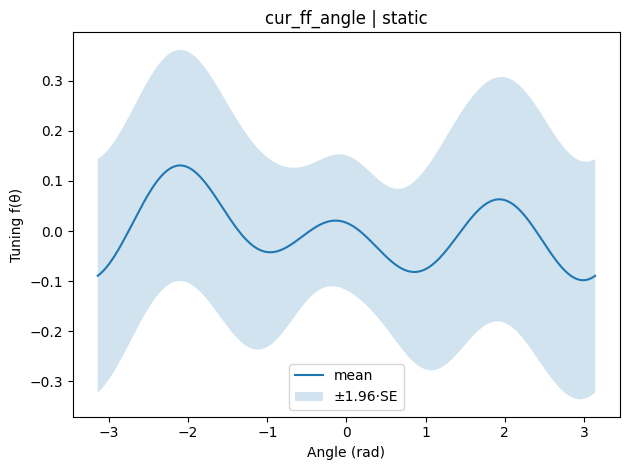

In [ ]:
theta, f, std, info =glm_plotting.plot_angle_tuning_function(
    res, design_df, meta,
    base_prefix='cur_ff_angle',
    M=None,                 # auto-detect harmonics
    polar=False,             # pretty polar plot
    z=1.96                  # 95% CI
)

theta, f, std, info =glm_plotting.plot_angle_tuning_function(
    res, design_df, meta,
    base_prefix='cur_ff_angle',
    M=None,                 # auto-detect harmonics
    polar=True,             # pretty polar plot
    z=1.96                  # 95% CI
)


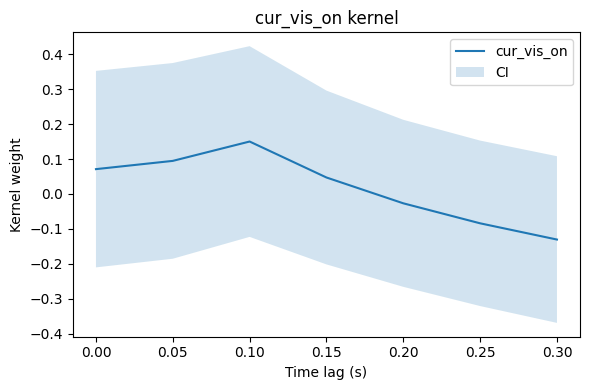

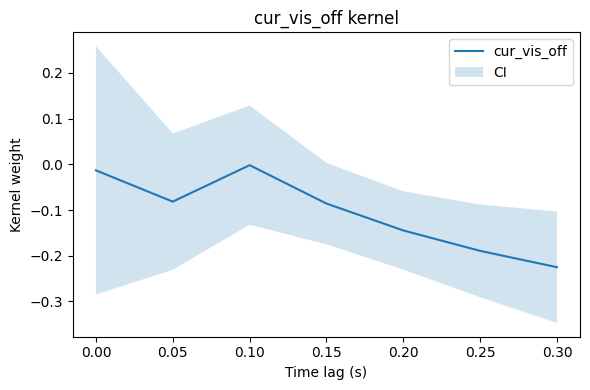

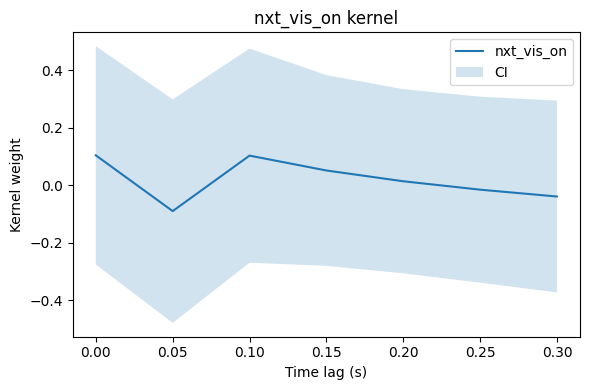

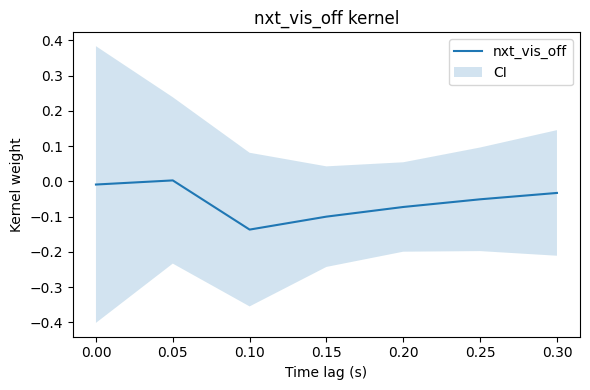

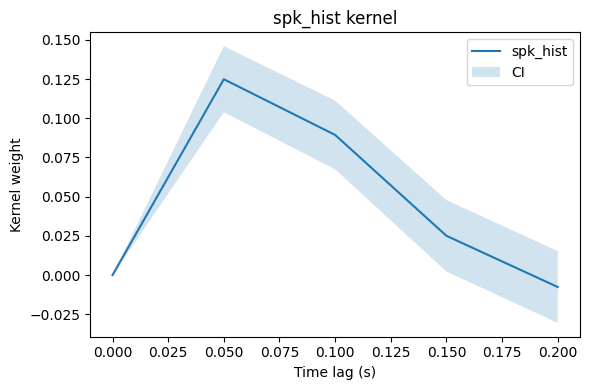

In [ ]:
glm_plotting.plot_fitted_kernels(
    res, design_df, meta, dt,
    prefixes=['cur_vis_on','cur_vis_off','nxt_vis_on','nxt_vis_off','spk_hist'],
    z=1.96  # 95% CI
)

## across neurons

In [ ]:
cluster_cols = [col for col in rebinned_x_var.columns if col.startswith('cluster_')]
cluster_nums = [int(col.split('_')[1]) for col in cluster_cols]

In [ ]:
results = []
designs = []
B_hist_ref = None

for cluster in cluster_nums:
    # .....
    
    
    
    
    # Fit GLM (cluster-robust by trial)
    res = fit_poisson_glm_trials(design_df, y_fit, dt, trial_ids, add_const=True, l2=0.0, cluster_se=False)
    results.append(res)
    designs.append(design_df)

meta = {"B_hist": B_hist_ref}

# Collect population history kernels
hist_df = collect_history_kernels_across_neurons(results, designs, meta, dt)

# Plot overlays + heatmap
plot_history_kernels_population(hist_df, overlay_mean=True, heatmap=True, max_overlays=50)

NameError: name 'simulate_spikes_with_trials' is not defined

In [ ]:
# Suppose you looped over N neurons and saved:
results = [res_n0, res_n1, ..., res_nN]         # statsmodels results
designs = [X_n0_df, X_n1_df, ..., X_nN_df]      # matching design DataFrames
meta    = meta_from_any_single_fit              # must contain 'B_hist'
dt      = 0.01                                  # your bin size (s)

hist_df = collect_history_kernels_across_neurons(
    results, designs, meta, dt, neuron_ids=None  # or e.g. list of unit IDs
)


# Overlay individual kernels (up to max_overlays) + population mean ± 95% CI
plot_history_kernels_population(hist_df, overlay_mean=True, heatmap=False, max_overlays=60)

# Heatmap only (neuron × lag)
plot_history_kernels_population(hist_df, overlay_mean=False, heatmap=True)

# Both
plot_history_kernels_population(hist_df, overlay_mean=True, heatmap=True)


